based on https://stackoverflow.com/questions/59381695/lstm-in-pytorch-how-to-add-change-sequence-length-dimension

In [1]:
from fastai.tabular import *
import pandas as pd
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
from tqdm import tqdm
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, Dataset, DataLoader
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline

# Data preparation

## Get the data

In [27]:
class CryptoDataset:
    """Face Landmarks dataset."""
    TARGET_COLUMN_NAME = 'close'
    DATE_COLUMN_NAME = 'date'
    ELAPSED = 'Elapsed'
    DROP_COLUMNS =['Second', 'Month', 'Year', \
                   'Is_quarter_end', 'Is_quarter_start', \
                   'Is_year_end', 'Is_year_start',
                   'Is_month_end', 'Is_month_start',
                   'Week', 'Dayofyear', ELAPSED]
    True_target_column_name = TARGET_COLUMN_NAME+'_future'

    def __init__(self, csv_file="BTC-ETH-filtered_with_indicators.csv", predict_delta=4, sequence_size=10, batch_size=8):
        """
        Args:
            csv_file (string): Path to the csv file with the crypto stats table.
        """
        from datetime import datetime
        self.sequence_size = sequence_size
        self.df = pd.read_csv("BTC-ETH-filtered_with_indicators.csv",
                              #read dates as dates
                              parse_dates=[self.DATE_COLUMN_NAME],
                              date_parser=lambda x: datetime.fromtimestamp(int(x)))
        add_datepart(self.df, self.DATE_COLUMN_NAME, time=True);
        self.df = self.df.astype(float).drop(columns=self.DROP_COLUMNS)
        self.df[self.True_target_column_name] = self.df[self.TARGET_COLUMN_NAME].shift(-predict_delta)
        trvate_split = tuple(int(x * len(self.df)) for x in (0.75, 0.9, 1.0))
        tmp_train_limit = trvate_split[0]- trvate_split[0]%sequence_size
        self.train_df = self.df[:tmp_train_limit]
        tmp_valid_limit = trvate_split[1] - trvate_split[0]%sequence_size -(trvate_split[1]-trvate_split[0])%sequence_size
        self.valid_df = self.df[tmp_train_limit:tmp_valid_limit]
        self.test_df = self.df[tmp_valid_limit:(len(self.df)- len(self.df)%sequence_size)]
        del tmp_train_limit, tmp_valid_limit
        
        def __transform_df(df_to_transform, transformer, columns):
            return pd.DataFrame(transformer.transform(df_to_transform), columns=columns)
        
        preprocessing_pipeline = Pipeline([("poli-feature", PolynomialFeatures(degree=2)),
                                           ("normalizer", StandardScaler())
                                          ]).fit(self.train_df.input_data(), self.train_df.target())
#         preprocessing_pipeline = StandardScaler().fit(self.train_df.input_data())
#         columns = self.train_df.input_data().columns
        columns = preprocessing_pipeline["poli-feature"].get_feature_names(self.train_df.input_data().columns)
        self.train_data = __transform_df(self.train_df.input_data(), preprocessing_pipeline, columns=columns)
        self.valid_data =__transform_df(self.valid_df.input_data(), preprocessing_pipeline, columns=columns)
        self.test_data = __transform_df(self.test_df.input_data(), preprocessing_pipeline, columns=columns)

        self.train_data.drop(columns=['1'], inplace=True)
        self.valid_data.drop(columns=['1'], inplace=True)
        self.test_data.drop(columns=['1'], inplace=True)
        
        def create_inout_sequences(input_data: pd.DataFrame, labels: pd.DataFrame, seq_len: int):
            out_labels = torch.tensor(labels.iloc[seq_len-1:].values.astype(np.float32))
            print(input_data.shape)
            out_sequences = np.stack([input_data.iloc[i:i+seq_len] for i in range(len(input_data)-seq_len+1)])
            out_data = torch.tensor(out_sequences.reshape(-1, seq_len, input_data.shape[-1]).astype(np.float32))
            print(input_data.shape, out_data.shape, out_labels.shape)
            return out_data, out_labels
        
#         train_x_y
        self.train_loader = DataLoader(dataset=TensorDataset(*create_inout_sequences(input_data=self.train_data,
                                                                                    labels=self.train_df.target(),
                                                                                    seq_len=sequence_size)),
                                       batch_size=batch_size, shuffle = True)
        self.val_loader = DataLoader(dataset=TensorDataset(*create_inout_sequences(input_data=self.valid_data,
                                                                                    labels=self.valid_df.target(),
                                                                                    seq_len=sequence_size)),
                                       batch_size=batch_size)
        self.test_loader = DataLoader(dataset=TensorDataset(*create_inout_sequences(input_data=self.test_data,
                                                                                    labels=self.test_df.target(),
                                                                                    seq_len=sequence_size)),
                                       batch_size=batch_size)

In [28]:
def input_data(self: pd.DataFrame):
    return self.drop(columns=[CryptoDataset.True_target_column_name])
def target(self: pd.DataFrame):
    return self[[CryptoDataset.True_target_column_name]]

pd.DataFrame.input_data = input_data
pd.DataFrame.target = target

### dataset build

In [16]:
BATCH_SIZE = 1
SEQUENCE_SIZE = 4
dataset=CryptoDataset(predict_delta=1,
                      batch_size=BATCH_SIZE,
                      sequence_size=SEQUENCE_SIZE)

(1044, 2015)
(1044, 2015) torch.Size([1041, 4, 2015]) torch.Size([1041, 1])
(208, 2015)
(208, 2015) torch.Size([205, 4, 2015]) torch.Size([205, 1])
(144, 2015)
(144, 2015) torch.Size([141, 4, 2015]) torch.Size([141, 1])


# Study

In [20]:
from IPython.display import display
pd.set_option('display.max_columns', 500)
np.set_printoptions(threshold=sys.maxsize)

In [7]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor()
rf.fit(dataset.train_df.input_data(), dataset.train_df.target())
print(rf.feature_importances_)

C:\Users\octav\Miniconda3\envs\tf_gpu\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\octav\Miniconda3\envs\tf_gpu\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


array([0.086826, 0.095778, 0.178001, 0.425084, ..., 0.      , 0.      , 0.      , 0.      ])

all columns
 ('open', 0.08682649302717294)
  ('high', 0.09577772052776405)
  ('low', 0.1780012443198402)
  ('close', 0.4250839387380988)
  ('volume', 0.0)
  ('fake', 0.0)
  ('volatility_atr', 0.0)
  ('volatility_bbh', 0.0)
  ('volatility_bbl', 0.0)
  ('volatility_bbm', 0.0)
  ('volatility_kcc', 0.0)
  ('volatility_kch', 0.0)
  ('volatility_kcl', 0.0)
  ('volatility_dch', 0.0)
  ('volatility_dcl', 0.0)
  ('trend_macd', 0.0)
  ('trend_macd_signal', 0.0)
  ('trend_macd_diff', 0.0)
  ('trend_ema_fast', 0.0)
  ('trend_ema_slow', 0.0)
  ('trend_adx', 0.0)
  ('trend_adx_pos', 0.0)
  ('trend_adx_neg', 0.0)
  ('trend_vortex_ind_pos', 0.0)
  ('trend_vortex_ind_neg', 0.0)
  ('trend_vortex_diff', 0.0)
  ('trend_trix', 0.0)
  ('trend_mass_index', 0.0)
  ('trend_cci', 0.0)
  ('trend_dpo', 0.0)
  ('trend_kst', 0.0)
  ('trend_kst_sig', 0.0)
  ('trend_kst_diff', 0.0)
  ('trend_ichimoku_a', 0.0)
  ('trend_ichimoku_b', 0.0)
  ('trend_visual_ichimoku_a', 0.0)
  ('trend_visual_ichimoku_b', 0.0)
  ('trend_a

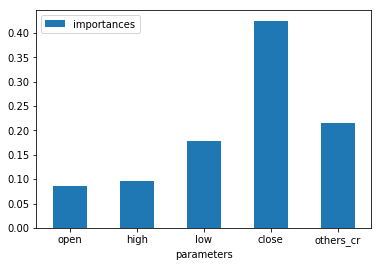

In [38]:
all_features = dataset.train_df.input_data().columns
print("all columns\n", *[str(a) +'\n ' for a in zip(all_features, rf.feature_importances_)])
plot_params = 'parameters'
plot_importances = 'importances'
df = pd.DataFrame({plot_params:all_features[rf.feature_importances_ > 0.].tolist(),
                   plot_importances:rf.feature_importances_[rf.feature_importances_ > 0.]})
ax = df.plot.bar(x=plot_params, y=plot_importances, rot=0)

In [29]:
def input_data(self: pd.DataFrame):
    return self[['open', 'high', 'low', 'close', 'others_cr']]
pd.DataFrame.input_data = input_data

In [36]:
BATCH_SIZE = 3
SEQUENCE_SIZE = 24
dataset=CryptoDataset(predict_delta=1,
                      batch_size=BATCH_SIZE,
                      sequence_size=SEQUENCE_SIZE)

(1032, 20)
(1032, 20) torch.Size([1009, 24, 20]) torch.Size([1009, 1])
(192, 20)
(192, 20) torch.Size([169, 24, 20]) torch.Size([169, 1])
(168, 20)
(168, 20) torch.Size([145, 24, 20]) torch.Size([145, 1])


# Train

In [31]:
# torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
DEVICE

device(type='cuda')

## Model

In [32]:
class SentimentNet(nn.Module):
    def __init__(self, features, output_size=1,
#                  embedding_dim=10,
#                  hidden_dim=50,
                 sequence_size=10,
                 n_layers=1,
                 drop_prob=0.5, device=torch.device("cpu")):
        super(SentimentNet, self).__init__()
        
        embedding_dim=features*2
        hidden_dim=features
        
        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        self.device = device
        
        self.liniar = nn.Linear(features, embedding_dim)
        self.bn1 = nn.BatchNorm1d(num_features=sequence_size) # embedding_dim)
        
        self.lstm = nn.LSTM(input_size=embedding_dim,
                            hidden_size=hidden_dim,
                            num_layers=n_layers, dropout=drop_prob, batch_first=True)
#         self.dropout = nn.Dropout(drop_prob)
        self.fc = nn.Sequential(nn.Linear(hidden_dim, hidden_dim//2),
                                nn.BatchNorm1d(num_features=hidden_dim//2),
                                nn.Dropout(drop_prob),
                                nn.Tanh(),
                                nn.Linear(hidden_dim//2, output_size))
        
    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.n_layers, x.size(0), self.hidden_dim).requires_grad_().to(self.device)
        # Initialize cell state
        c0 = torch.zeros(self.n_layers, x.size(0), self.hidden_dim).requires_grad_().to(self.device)
        
        out = self.liniar(x)
#         print(out.shape)
        out = F.relu(self.bn1(out))
#         print(out.shape)
        out, (hn, cn) = self.lstm(out, (h0, c0))
#         print(out.shape)
        # Index hidden state of last time step
        out = self.fc(out[:, -1, :])
        
        return out

In [6]:
# class CustomLoss(nn.L1Loss):
#     def __init__(self, size_average=None, reduce=None, reduction='mean'):
#         super(CustomLoss, self).__init__(size_average, reduce, reduction)

#     def forward(self, input, target):
#         return 10.0 * F.l1_loss(input, target, reduction=self.reduction)
        

In [37]:
features_count = dataset.train_data.shape[1]
# output_size = 1
# embedding_dim = 400
# hidden_dim = 512
# n_layers = 2

model = SentimentNet(features_count, device=DEVICE, n_layers=3, sequence_size=SEQUENCE_SIZE)
model.to(DEVICE)

lr=0.001
# criterion = CustomLoss()
criterion = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

epochs = 200
counter = 0
print_every = 5
clip = 5
valid_loss_min = np.Inf
lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=lr,
                                                   steps_per_epoch=len(dataset.train_loader),
                                                   epochs=epochs)

In [38]:
model.train()

for epoch in range(epochs):
    for train, train_target in dataset.train_loader:
        if train.shape[0] < 2:
            continue
            
        counter += 1
        # Load data as a torch tensor with gradient accumulation abilities
        train = train.requires_grad_().to(DEVICE)
        train_target = train_target.to(DEVICE)
#         print(train.shape)
#         print(train_target.shape)

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()
        # Forward pass to get output/logits
        outputs = model(train)

        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, train_target)

        # Getting gradients w.r.t. parameters
        loss.backward()
        # Updating parameters
#         nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        lr_scheduler.step()
        
        # evaluate every x iterations. save model if val error decreased
    
        if counter%print_every == 0:
            #start eval mode
            model.eval()
            val_losses = []
            
            for val_in, val_out in dataset.val_loader:
                # Forward pass to get output/logits
                val_in = val_in.to(DEVICE)
                val_out = val_out.to(DEVICE)
                outputs = model(val_in)
                val_loss = criterion(outputs, val_out)
                val_losses.append(val_loss.item())
            
            print("Epoch: {}/{}...".format(epoch+1, epochs),
                  "Step: {}...".format(counter),
                  "Loss: {:.6f}...".format(loss.item()),
                  "Val Loss: {:.6f}".format(np.mean(val_losses)))
            if np.mean(val_losses) < valid_loss_min:
                torch.save(model.state_dict(), './state_dict8.pt')
                print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,np.mean(val_losses)))
                valid_loss_min = np.mean(val_losses)
                
            # back to train mode
            model.train()

torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 1/200... Step: 5... Loss: 0.203168... Val Loss: 0.144698
Validation loss decreased (inf --> 0.144698).  Saving model ...
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 1/200... Step: 10... Loss: 0.323321... Val Loss: 0.155697
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 1/200... Step: 15... Loss: 0.175625... Val Loss: 0.162396
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 1/200... Step: 20... Loss: 0.260953... Val Loss: 0.165239
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 1/200... Step: 25... Loss: 0.251038... Val Loss: 0.162989
torch.Size([

Epoch: 1/200... Step: 205... Loss: 0.188950... Val Loss: 0.040781
Validation loss decreased (0.043081 --> 0.040781).  Saving model ...
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 1/200... Step: 210... Loss: 0.372768... Val Loss: 0.035708
Validation loss decreased (0.040781 --> 0.035708).  Saving model ...
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 1/200... Step: 215... Loss: 0.199889... Val Loss: 0.046555
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 1/200... Step: 220... Loss: 0.444668... Val Loss: 0.065090
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 1/200... Step: 225... Loss: 0.173603... Val Loss: 0.055843
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torc

torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 2/200... Step: 415... Loss: 0.282063... Val Loss: 0.121257
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 2/200... Step: 420... Loss: 0.230602... Val Loss: 0.102355
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 2/200... Step: 425... Loss: 0.273022... Val Loss: 0.097862
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 2/200... Step: 430... Loss: 0.311532... Val Loss: 0.126315
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 2/200... Step: 435... Loss: 0.150764... Val Loss: 0.137384
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 2/200... Step: 

torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 2/200... Step: 635... Loss: 0.108115... Val Loss: 0.041251
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 2/200... Step: 640... Loss: 0.324245... Val Loss: 0.153438
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 2/200... Step: 645... Loss: 0.372104... Val Loss: 0.111983
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 2/200... Step: 650... Loss: 0.207377... Val Loss: 0.131395
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 2/200... Step: 655... Loss: 0.246966... Val Loss: 0.092495
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20]

torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 3/200... Step: 855... Loss: 0.203880... Val Loss: 0.101499
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 3/200... Step: 860... Loss: 0.226304... Val Loss: 0.107289
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 3/200... Step: 865... Loss: 0.139978... Val Loss: 0.047283
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 3/200... Step: 870... Loss: 0.641114... Val Loss: 0.066165
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 3/200... Step: 875... Loss: 0.269018... Val Loss: 0.134472
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20]

Epoch: 4/200... Step: 1070... Loss: 0.186644... Val Loss: 0.075259
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 4/200... Step: 1075... Loss: 0.402846... Val Loss: 0.133674
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 4/200... Step: 1080... Loss: 0.298687... Val Loss: 0.078943
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 4/200... Step: 1085... Loss: 0.243607... Val Loss: 0.043756
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 4/200... Step: 1090... Loss: 0.092272... Val Loss: 0.102123
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 4/200... Step: 1095... Loss: 0.286835... Val Loss: 0.08513

torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 4/200... Step: 1290... Loss: 0.327000... Val Loss: 0.070977
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 4/200... Step: 1295... Loss: 0.397773... Val Loss: 0.133505
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 4/200... Step: 1300... Loss: 0.315582... Val Loss: 0.099361
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 4/200... Step: 1305... Loss: 0.117175... Val Loss: 0.058826
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 4/200... Step: 1310... Loss: 0.219220... Val Loss: 0.101279
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24

Epoch: 5/200... Step: 1505... Loss: 0.158096... Val Loss: 0.075461
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 5/200... Step: 1510... Loss: 0.084598... Val Loss: 0.037692
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 5/200... Step: 1515... Loss: 0.215153... Val Loss: 0.109600
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 5/200... Step: 1520... Loss: 0.391110... Val Loss: 0.107386
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 5/200... Step: 1525... Loss: 0.267790... Val Loss: 0.153691
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 5/200... Step: 1530... Loss: 0.300104... Val Loss: 0.09464

torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 6/200... Step: 1725... Loss: 0.321553... Val Loss: 0.078749
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 6/200... Step: 1730... Loss: 0.169054... Val Loss: 0.074506
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 6/200... Step: 1735... Loss: 0.251195... Val Loss: 0.088272
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 6/200... Step: 1740... Loss: 0.197141... Val Loss: 0.094134
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 6/200... Step: 1745... Loss: 0.353016... Val Loss: 0.088187
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 6/200... S

Epoch: 6/200... Step: 1940... Loss: 0.266862... Val Loss: 0.070267
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 6/200... Step: 1945... Loss: 0.370468... Val Loss: 0.068121
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 6/200... Step: 1950... Loss: 0.263708... Val Loss: 0.058198
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 6/200... Step: 1955... Loss: 0.423980... Val Loss: 0.091607
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 6/200... Step: 1960... Loss: 0.248197... Val Loss: 0.041729
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 6/200... Step: 1965... Loss: 0.164805... Val Loss: 0.07502

torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 7/200... Step: 2160... Loss: 0.385074... Val Loss: 0.097813
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 7/200... Step: 2165... Loss: 0.179689... Val Loss: 0.088927
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 7/200... Step: 2170... Loss: 0.296876... Val Loss: 0.045596
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 7/200... Step: 2175... Loss: 0.211090... Val Loss: 0.075931
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 7/200... Step: 2180... Loss: 0.377232... Val Loss: 0.049457
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 7/200... S

Epoch: 8/200... Step: 2375... Loss: 0.290974... Val Loss: 0.037259
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 8/200... Step: 2380... Loss: 0.300433... Val Loss: 0.033468
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 8/200... Step: 2385... Loss: 0.126702... Val Loss: 0.043022
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 8/200... Step: 2390... Loss: 0.259671... Val Loss: 0.046251
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 8/200... Step: 2395... Loss: 0.419564... Val Loss: 0.094413
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 8/200... Step: 2400... Loss: 0.099695... Val Loss: 0.08111

torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 8/200... Step: 2595... Loss: 0.241378... Val Loss: 0.123895
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 8/200... Step: 2600... Loss: 0.221623... Val Loss: 0.122371
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 8/200... Step: 2605... Loss: 0.156153... Val Loss: 0.124412
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 8/200... Step: 2610... Loss: 0.336601... Val Loss: 0.104937
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 8/200... Step: 2615... Loss: 0.197959... Val Loss: 0.049391
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 8/200... S

torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 9/200... Step: 2815... Loss: 0.442483... Val Loss: 0.010306
Validation loss decreased (0.010765 --> 0.010306).  Saving model ...
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 9/200... Step: 2820... Loss: 0.127975... Val Loss: 0.024897
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 9/200... Step: 2825... Loss: 0.219587... Val Loss: 0.043539
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 9/200... Step: 2830... Loss: 0.149376... Val Loss: 0.020958
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 9/200... Step: 2835... Loss: 0.307321... Val Loss: 0.036156
torch.Size([3, 24, 2

torch.Size([3, 24, 20])
Epoch: 10/200... Step: 3030... Loss: 0.123563... Val Loss: 0.097617
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 10/200... Step: 3035... Loss: 0.389531... Val Loss: 0.089500
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 10/200... Step: 3040... Loss: 0.386498... Val Loss: 0.120975
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 10/200... Step: 3045... Loss: 0.211000... Val Loss: 0.104223
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 10/200... Step: 3050... Loss: 0.033769... Val Loss: 0.084220
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 10/200... Step: 3055... Loss:

Epoch: 10/200... Step: 3245... Loss: 0.296942... Val Loss: 0.048182
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 10/200... Step: 3250... Loss: 0.163553... Val Loss: 0.026315
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 10/200... Step: 3255... Loss: 0.344318... Val Loss: 0.011470
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 10/200... Step: 3260... Loss: 0.219828... Val Loss: 0.039149
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 10/200... Step: 3265... Loss: 0.332773... Val Loss: 0.030359
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 10/200... Step: 3270... Loss: 0.162527... Val Loss: 0

torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 11/200... Step: 3465... Loss: 0.205217... Val Loss: 0.060392
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 11/200... Step: 3470... Loss: 0.150884... Val Loss: 0.069050
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 11/200... Step: 3475... Loss: 0.127571... Val Loss: 0.059881
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 11/200... Step: 3480... Loss: 0.053699... Val Loss: 0.047455
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 11/200... Step: 3485... Loss: 0.163471... Val Loss: 0.043255
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([

Epoch: 11/200... Step: 3675... Loss: 0.222225... Val Loss: 0.017029
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 11/200... Step: 3680... Loss: 0.110733... Val Loss: 0.022304
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 11/200... Step: 3685... Loss: 0.048525... Val Loss: 0.022647
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 11/200... Step: 3690... Loss: 0.129909... Val Loss: 0.034473
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 11/200... Step: 3695... Loss: 0.132872... Val Loss: 0.058340
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 12/200... Step: 3700... Loss: 0.164958... Val Loss: 0

torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 12/200... Step: 3895... Loss: 0.100138... Val Loss: 0.039069
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 12/200... Step: 3900... Loss: 0.142383... Val Loss: 0.023768
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 12/200... Step: 3905... Loss: 0.206186... Val Loss: 0.045072
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 12/200... Step: 3910... Loss: 0.163273... Val Loss: 0.032010
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 12/200... Step: 3915... Loss: 0.146746... Val Loss: 0.018947
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([

torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 13/200... Step: 4105... Loss: 0.141315... Val Loss: 0.031551
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 13/200... Step: 4110... Loss: 0.094710... Val Loss: 0.015752
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 13/200... Step: 4115... Loss: 0.147641... Val Loss: 0.009103
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 13/200... Step: 4120... Loss: 0.122790... Val Loss: 0.003804
Validation loss decreased (0.004597 --> 0.003804).  Saving model ...
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 13/200... Step: 4125... Loss: 0.123044... Val Loss: 0.007366
torch.Size([3, 

torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 13/200... Step: 4320... Loss: 0.169772... Val Loss: 0.020805
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 13/200... Step: 4325... Loss: 0.076004... Val Loss: 0.020396
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 13/200... Step: 4330... Loss: 0.174290... Val Loss: 0.024997
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 13/200... Step: 4335... Loss: 0.112400... Val Loss: 0.037951
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 13/200... Step: 4340... Loss: 0.043733... Val Loss: 0.027089
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([

torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 14/200... Step: 4535... Loss: 0.027275... Val Loss: 0.027000
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 14/200... Step: 4540... Loss: 0.086832... Val Loss: 0.034748
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 14/200... Step: 4545... Loss: 0.124860... Val Loss: 0.037243
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 14/200... Step: 4550... Loss: 0.101347... Val Loss: 0.045726
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 14/200... Step: 4555... Loss: 0.110047... Val Loss: 0.040740
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 14/20

Epoch: 15/200... Step: 4750... Loss: 0.133468... Val Loss: 0.029065
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 15/200... Step: 4755... Loss: 0.065583... Val Loss: 0.032993
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 15/200... Step: 4760... Loss: 0.175644... Val Loss: 0.027933
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 15/200... Step: 4765... Loss: 0.091430... Val Loss: 0.025819
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 15/200... Step: 4770... Loss: 0.113420... Val Loss: 0.035122
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 15/200... Step: 4775... Loss: 0.022377... Val Loss: 0

torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 15/200... Step: 4970... Loss: 0.058711... Val Loss: 0.009094
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 15/200... Step: 4975... Loss: 0.036798... Val Loss: 0.012309
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 15/200... Step: 4980... Loss: 0.050753... Val Loss: 0.006467
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 15/200... Step: 4985... Loss: 0.067926... Val Loss: 0.004076
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 15/200... Step: 4990... Loss: 0.099206... Val Loss: 0.007915
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([

Epoch: 16/200... Step: 5185... Loss: 0.087278... Val Loss: 0.004524
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 16/200... Step: 5190... Loss: 0.085142... Val Loss: 0.005711
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 16/200... Step: 5195... Loss: 0.048030... Val Loss: 0.005730
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 16/200... Step: 5200... Loss: 0.058409... Val Loss: 0.005784
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 16/200... Step: 5205... Loss: 0.081265... Val Loss: 0.006079
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 16/200... Step: 5210... Loss: 0.067571... Val Loss: 0

Epoch: 17/200... Step: 5400... Loss: 0.060168... Val Loss: 0.011258
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 17/200... Step: 5405... Loss: 0.100504... Val Loss: 0.005110
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 17/200... Step: 5410... Loss: 0.091232... Val Loss: 0.006134
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 17/200... Step: 5415... Loss: 0.083724... Val Loss: 0.006953
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 17/200... Step: 5420... Loss: 0.072814... Val Loss: 0.008779
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 17/200... Step: 5425... Loss: 0.014926... Val Loss: 0

Epoch: 17/200... Step: 5615... Loss: 0.029594... Val Loss: 0.004635
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 17/200... Step: 5620... Loss: 0.063233... Val Loss: 0.002834
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 17/200... Step: 5625... Loss: 0.050828... Val Loss: 0.001701
Validation loss decreased (0.002150 --> 0.001701).  Saving model ...
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 17/200... Step: 5630... Loss: 0.026790... Val Loss: 0.002260
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 17/200... Step: 5635... Loss: 0.055698... Val Loss: 0.002783
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 

torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 18/200... Step: 5830... Loss: 0.029090... Val Loss: 0.001507
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 18/200... Step: 5835... Loss: 0.031267... Val Loss: 0.003115
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 18/200... Step: 5840... Loss: 0.039911... Val Loss: 0.002675
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 18/200... Step: 5845... Loss: 0.038631... Val Loss: 0.001493
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 18/200... Step: 5850... Loss: 0.018471... Val Loss: 0.001095
Validation loss decreased (0.001252 --> 0.001095).  Saving m

torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 18/200... Step: 6040... Loss: 0.018800... Val Loss: 0.000633
Validation loss decreased (0.000733 --> 0.000633).  Saving model ...
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 18/200... Step: 6045... Loss: 0.015329... Val Loss: 0.001398
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 19/200... Step: 6050... Loss: 0.013460... Val Loss: 0.000832
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 19/200... Step: 6055... Loss: 0.011972... Val Loss: 0.000509
Validation loss decreased (0.000633 --> 0.000509).  Saving model ...
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 19/200... Step: 6060... Loss: 0.009325... Val Loss: 0.0

torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 19/200... Step: 6250... Loss: 0.001126... Val Loss: 0.000304
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 19/200... Step: 6255... Loss: 0.000466... Val Loss: 0.000224
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 19/200... Step: 6260... Loss: 0.000926... Val Loss: 0.000214
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 19/200... Step: 6265... Loss: 0.000870... Val Loss: 0.000216
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 19/200... Step: 6270... Loss: 0.000848... Val Loss: 0.000245
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([

Epoch: 20/200... Step: 6465... Loss: 0.000751... Val Loss: 0.000149
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 20/200... Step: 6470... Loss: 0.000981... Val Loss: 0.000526
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 20/200... Step: 6475... Loss: 0.001067... Val Loss: 0.000678
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 20/200... Step: 6480... Loss: 0.000780... Val Loss: 0.000108
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 20/200... Step: 6485... Loss: 0.001656... Val Loss: 0.000239
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 20/200... Step: 6490... Loss: 0.000786... Val Loss: 0

torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 20/200... Step: 6685... Loss: 0.000846... Val Loss: 0.000625
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 20/200... Step: 6690... Loss: 0.000938... Val Loss: 0.000597
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 20/200... Step: 6695... Loss: 0.000313... Val Loss: 0.000151
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 20/200... Step: 6700... Loss: 0.000758... Val Loss: 0.000498
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 20/200... Step: 6705... Loss: 0.000872... Val Loss: 0.000145
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([

Epoch: 21/200... Step: 6900... Loss: 0.000810... Val Loss: 0.000296
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 21/200... Step: 6905... Loss: 0.000808... Val Loss: 0.000881
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 21/200... Step: 6910... Loss: 0.001737... Val Loss: 0.001021
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 21/200... Step: 6915... Loss: 0.000758... Val Loss: 0.000294
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 21/200... Step: 6920... Loss: 0.000448... Val Loss: 0.000377
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 21/200... Step: 6925... Loss: 0.000561... Val Loss: 0

torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 22/200... Step: 7120... Loss: 0.000642... Val Loss: 0.000633
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 22/200... Step: 7125... Loss: 0.000606... Val Loss: 0.000280
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 22/200... Step: 7130... Loss: 0.000935... Val Loss: 0.000404
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 22/200... Step: 7135... Loss: 0.001335... Val Loss: 0.000667
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 22/200... Step: 7140... Loss: 0.001187... Val Loss: 0.000461
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([

torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 22/200... Step: 7335... Loss: 0.001000... Val Loss: 0.000433
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 22/200... Step: 7340... Loss: 0.000533... Val Loss: 0.000255
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 22/200... Step: 7345... Loss: 0.001251... Val Loss: 0.000620
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 22/200... Step: 7350... Loss: 0.000751... Val Loss: 0.000221
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 22/200... Step: 7355... Loss: 0.000787... Val Loss: 0.000186
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([

Epoch: 23/200... Step: 7550... Loss: 0.000861... Val Loss: 0.000798
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 23/200... Step: 7555... Loss: 0.001051... Val Loss: 0.001303
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 23/200... Step: 7560... Loss: 0.000691... Val Loss: 0.000450
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 23/200... Step: 7565... Loss: 0.000826... Val Loss: 0.000201
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 23/200... Step: 7570... Loss: 0.000433... Val Loss: 0.000272
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 23/200... Step: 7575... Loss: 0.000271... Val Loss: 0

torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 24/200... Step: 7770... Loss: 0.000588... Val Loss: 0.000693
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 24/200... Step: 7775... Loss: 0.001141... Val Loss: 0.000138
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 24/200... Step: 7780... Loss: 0.000755... Val Loss: 0.000340
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 24/200... Step: 7785... Loss: 0.001389... Val Loss: 0.000304
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 24/200... Step: 7790... Loss: 0.001328... Val Loss: 0.000333
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([

Epoch: 24/200... Step: 7985... Loss: 0.000959... Val Loss: 0.000328
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 24/200... Step: 7990... Loss: 0.000605... Val Loss: 0.000510
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 24/200... Step: 7995... Loss: 0.000772... Val Loss: 0.000224
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 24/200... Step: 8000... Loss: 0.000642... Val Loss: 0.000510
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 24/200... Step: 8005... Loss: 0.000835... Val Loss: 0.001054
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 24/200... Step: 8010... Loss: 0.000593... Val Loss: 0

torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 25/200... Step: 8205... Loss: 0.000852... Val Loss: 0.000255
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 25/200... Step: 8210... Loss: 0.001153... Val Loss: 0.000534
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 25/200... Step: 8215... Loss: 0.001755... Val Loss: 0.000354
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 25/200... Step: 8220... Loss: 0.000517... Val Loss: 0.000165
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 25/200... Step: 8225... Loss: 0.001050... Val Loss: 0.000136
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([

Epoch: 26/200... Step: 8420... Loss: 0.001470... Val Loss: 0.001463
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 26/200... Step: 8425... Loss: 0.000660... Val Loss: 0.000923
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 26/200... Step: 8430... Loss: 0.001319... Val Loss: 0.000353
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 26/200... Step: 8435... Loss: 0.000587... Val Loss: 0.000826
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 26/200... Step: 8440... Loss: 0.001599... Val Loss: 0.001411
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 26/200... Step: 8445... Loss: 0.001219... Val Loss: 0

torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 26/200... Step: 8640... Loss: 0.001237... Val Loss: 0.000331
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 26/200... Step: 8645... Loss: 0.001181... Val Loss: 0.000604
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 26/200... Step: 8650... Loss: 0.002241... Val Loss: 0.000879
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 26/200... Step: 8655... Loss: 0.001531... Val Loss: 0.001009
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 26/200... Step: 8660... Loss: 0.001017... Val Loss: 0.000744
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([

Epoch: 27/200... Step: 8855... Loss: 0.001583... Val Loss: 0.000235
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 27/200... Step: 8860... Loss: 0.000766... Val Loss: 0.000259
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 27/200... Step: 8865... Loss: 0.001270... Val Loss: 0.000283
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 27/200... Step: 8870... Loss: 0.001389... Val Loss: 0.000541
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 27/200... Step: 8875... Loss: 0.001015... Val Loss: 0.000224
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 27/200... Step: 8880... Loss: 0.001197... Val Loss: 0

torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 28/200... Step: 9075... Loss: 0.000210... Val Loss: 0.000180
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 28/200... Step: 9080... Loss: 0.000827... Val Loss: 0.001352
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 28/200... Step: 9085... Loss: 0.002554... Val Loss: 0.001101
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 28/200... Step: 9090... Loss: 0.000637... Val Loss: 0.000317
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 28/200... Step: 9095... Loss: 0.000547... Val Loss: 0.000589
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([

Epoch: 28/200... Step: 9290... Loss: 0.000470... Val Loss: 0.001120
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 28/200... Step: 9295... Loss: 0.000248... Val Loss: 0.000194
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 28/200... Step: 9300... Loss: 0.000502... Val Loss: 0.000465
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 28/200... Step: 9305... Loss: 0.000859... Val Loss: 0.000656
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 28/200... Step: 9310... Loss: 0.001019... Val Loss: 0.000307
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 28/200... Step: 9315... Loss: 0.000753... Val Loss: 0

torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 29/200... Step: 9510... Loss: 0.001072... Val Loss: 0.000487
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 29/200... Step: 9515... Loss: 0.001186... Val Loss: 0.000302
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 29/200... Step: 9520... Loss: 0.001148... Val Loss: 0.001666
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 29/200... Step: 9525... Loss: 0.000908... Val Loss: 0.001600
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 29/200... Step: 9530... Loss: 0.000474... Val Loss: 0.000434
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([

Epoch: 29/200... Step: 9725... Loss: 0.002442... Val Loss: 0.000192
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 29/200... Step: 9730... Loss: 0.001552... Val Loss: 0.000362
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 29/200... Step: 9735... Loss: 0.001250... Val Loss: 0.000270
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 29/200... Step: 9740... Loss: 0.001370... Val Loss: 0.000458
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 30/200... Step: 9745... Loss: 0.000374... Val Loss: 0.000574
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 30/200... Step: 9750... Loss: 0.001397... Val Loss: 0

torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 30/200... Step: 9945... Loss: 0.001624... Val Loss: 0.001775
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 30/200... Step: 9950... Loss: 0.001131... Val Loss: 0.000804
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 30/200... Step: 9955... Loss: 0.001832... Val Loss: 0.000607
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 30/200... Step: 9960... Loss: 0.001321... Val Loss: 0.001009
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 30/200... Step: 9965... Loss: 0.000681... Val Loss: 0.000338
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([

torch.Size([3, 24, 20])
Epoch: 31/200... Step: 10160... Loss: 0.002375... Val Loss: 0.000970
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 31/200... Step: 10165... Loss: 0.000537... Val Loss: 0.001004
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 31/200... Step: 10170... Loss: 0.001626... Val Loss: 0.000331
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 31/200... Step: 10175... Loss: 0.000275... Val Loss: 0.000687
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 31/200... Step: 10180... Loss: 0.001334... Val Loss: 0.000665
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 31/200... Step: 10185...

Epoch: 31/200... Step: 10375... Loss: 0.001209... Val Loss: 0.000750
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 31/200... Step: 10380... Loss: 0.000601... Val Loss: 0.000475
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 31/200... Step: 10385... Loss: 0.000990... Val Loss: 0.000338
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 31/200... Step: 10390... Loss: 0.001357... Val Loss: 0.000189
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 31/200... Step: 10395... Loss: 0.001116... Val Loss: 0.000348
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 31/200... Step: 10400... Loss: 0.001063... Val L

Epoch: 32/200... Step: 10590... Loss: 0.002419... Val Loss: 0.001101
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 32/200... Step: 10595... Loss: 0.001107... Val Loss: 0.000597
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 32/200... Step: 10600... Loss: 0.001277... Val Loss: 0.000161
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 32/200... Step: 10605... Loss: 0.003175... Val Loss: 0.001874
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 32/200... Step: 10610... Loss: 0.002188... Val Loss: 0.002612
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 32/200... Step: 10615... Loss: 0.000256... Val L

Epoch: 33/200... Step: 10805... Loss: 0.001025... Val Loss: 0.001945
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 33/200... Step: 10810... Loss: 0.001478... Val Loss: 0.000981
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 33/200... Step: 10815... Loss: 0.001562... Val Loss: 0.000915
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 33/200... Step: 10820... Loss: 0.001597... Val Loss: 0.001868
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 33/200... Step: 10825... Loss: 0.001593... Val Loss: 0.001415
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 33/200... Step: 10830... Loss: 0.001109... Val L

Epoch: 33/200... Step: 11020... Loss: 0.001464... Val Loss: 0.000581
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 33/200... Step: 11025... Loss: 0.000666... Val Loss: 0.000921
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 33/200... Step: 11030... Loss: 0.000434... Val Loss: 0.000278
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 33/200... Step: 11035... Loss: 0.000498... Val Loss: 0.001086
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 33/200... Step: 11040... Loss: 0.001196... Val Loss: 0.001528
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 33/200... Step: 11045... Loss: 0.001221... Val L

Epoch: 34/200... Step: 11235... Loss: 0.000853... Val Loss: 0.000224
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 34/200... Step: 11240... Loss: 0.001509... Val Loss: 0.000203
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 34/200... Step: 11245... Loss: 0.001184... Val Loss: 0.000497
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 34/200... Step: 11250... Loss: 0.000633... Val Loss: 0.001535
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 34/200... Step: 11255... Loss: 0.001025... Val Loss: 0.001664
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 34/200... Step: 11260... Loss: 0.001342... Val L

Epoch: 35/200... Step: 11450... Loss: 0.001436... Val Loss: 0.000284
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 35/200... Step: 11455... Loss: 0.001172... Val Loss: 0.000905
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 35/200... Step: 11460... Loss: 0.001134... Val Loss: 0.000519
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 35/200... Step: 11465... Loss: 0.000948... Val Loss: 0.001591
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 35/200... Step: 11470... Loss: 0.000944... Val Loss: 0.000549
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 35/200... Step: 11475... Loss: 0.001390... Val L

Epoch: 35/200... Step: 11665... Loss: 0.000915... Val Loss: 0.000324
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 35/200... Step: 11670... Loss: 0.000867... Val Loss: 0.000120
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 35/200... Step: 11675... Loss: 0.001486... Val Loss: 0.001127
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 35/200... Step: 11680... Loss: 0.000593... Val Loss: 0.000741
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 35/200... Step: 11685... Loss: 0.000786... Val Loss: 0.000563
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 35/200... Step: 11690... Loss: 0.001632... Val L

Epoch: 36/200... Step: 11880... Loss: 0.001438... Val Loss: 0.000642
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 36/200... Step: 11885... Loss: 0.001064... Val Loss: 0.000192
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 36/200... Step: 11890... Loss: 0.001323... Val Loss: 0.000663
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 36/200... Step: 11895... Loss: 0.000514... Val Loss: 0.000191
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 36/200... Step: 11900... Loss: 0.002311... Val Loss: 0.000836
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 36/200... Step: 11905... Loss: 0.000728... Val L

Epoch: 36/200... Step: 12095... Loss: 0.002037... Val Loss: 0.000644
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 37/200... Step: 12100... Loss: 0.000581... Val Loss: 0.000328
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 37/200... Step: 12105... Loss: 0.000781... Val Loss: 0.001726
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 37/200... Step: 12110... Loss: 0.000985... Val Loss: 0.001750
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 37/200... Step: 12115... Loss: 0.000829... Val Loss: 0.001154
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 37/200... Step: 12120... Loss: 0.000454... Val L

Epoch: 37/200... Step: 12310... Loss: 0.001617... Val Loss: 0.002624
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 37/200... Step: 12315... Loss: 0.001845... Val Loss: 0.000351
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 37/200... Step: 12320... Loss: 0.002600... Val Loss: 0.000276
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 37/200... Step: 12325... Loss: 0.001032... Val Loss: 0.000868
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 37/200... Step: 12330... Loss: 0.002199... Val Loss: 0.000912
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 37/200... Step: 12335... Loss: 0.000932... Val L

Epoch: 38/200... Step: 12525... Loss: 0.000977... Val Loss: 0.000774
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 38/200... Step: 12530... Loss: 0.000443... Val Loss: 0.001641
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 38/200... Step: 12535... Loss: 0.001437... Val Loss: 0.000235
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 38/200... Step: 12540... Loss: 0.001217... Val Loss: 0.002274
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 38/200... Step: 12545... Loss: 0.000986... Val Loss: 0.000644
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 38/200... Step: 12550... Loss: 0.002177... Val L

Epoch: 38/200... Step: 12740... Loss: 0.001552... Val Loss: 0.000508
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 38/200... Step: 12745... Loss: 0.001598... Val Loss: 0.001083
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 38/200... Step: 12750... Loss: 0.000850... Val Loss: 0.001132
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 38/200... Step: 12755... Loss: 0.002502... Val Loss: 0.001572
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 38/200... Step: 12760... Loss: 0.001196... Val Loss: 0.001089
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 38/200... Step: 12765... Loss: 0.001541... Val L

Epoch: 39/200... Step: 12955... Loss: 0.001974... Val Loss: 0.000543
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 39/200... Step: 12960... Loss: 0.001662... Val Loss: 0.001273
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 39/200... Step: 12965... Loss: 0.001885... Val Loss: 0.001036
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 39/200... Step: 12970... Loss: 0.001186... Val Loss: 0.000963
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 39/200... Step: 12975... Loss: 0.002122... Val Loss: 0.001318
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 39/200... Step: 12980... Loss: 0.001135... Val L

Epoch: 40/200... Step: 13170... Loss: 0.002030... Val Loss: 0.002743
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 40/200... Step: 13175... Loss: 0.000893... Val Loss: 0.002257
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 40/200... Step: 13180... Loss: 0.000739... Val Loss: 0.000254
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 40/200... Step: 13185... Loss: 0.000357... Val Loss: 0.000183
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 40/200... Step: 13190... Loss: 0.000575... Val Loss: 0.000698
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 40/200... Step: 13195... Loss: 0.001777... Val L

Epoch: 40/200... Step: 13385... Loss: 0.001424... Val Loss: 0.002417
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 40/200... Step: 13390... Loss: 0.000168... Val Loss: 0.000603
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 40/200... Step: 13395... Loss: 0.002029... Val Loss: 0.000824
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 40/200... Step: 13400... Loss: 0.001370... Val Loss: 0.000374
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 40/200... Step: 13405... Loss: 0.001450... Val Loss: 0.000476
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 40/200... Step: 13410... Loss: 0.000888... Val L

Epoch: 41/200... Step: 13600... Loss: 0.001059... Val Loss: 0.000574
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 41/200... Step: 13605... Loss: 0.001776... Val Loss: 0.000335
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 41/200... Step: 13610... Loss: 0.000640... Val Loss: 0.001687
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 41/200... Step: 13615... Loss: 0.001822... Val Loss: 0.001836
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 41/200... Step: 13620... Loss: 0.000601... Val Loss: 0.000254
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 41/200... Step: 13625... Loss: 0.001030... Val L

Epoch: 42/200... Step: 13815... Loss: 0.002325... Val Loss: 0.002891
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 42/200... Step: 13820... Loss: 0.000667... Val Loss: 0.000270
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 42/200... Step: 13825... Loss: 0.000902... Val Loss: 0.000407
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 42/200... Step: 13830... Loss: 0.000511... Val Loss: 0.000177
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 42/200... Step: 13835... Loss: 0.000300... Val Loss: 0.000541
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 42/200... Step: 13840... Loss: 0.000617... Val L

Epoch: 42/200... Step: 14030... Loss: 0.001352... Val Loss: 0.001134
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 42/200... Step: 14035... Loss: 0.000648... Val Loss: 0.000277
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 42/200... Step: 14040... Loss: 0.001257... Val Loss: 0.000430
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 42/200... Step: 14045... Loss: 0.000782... Val Loss: 0.000136
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 42/200... Step: 14050... Loss: 0.001386... Val Loss: 0.000365
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 42/200... Step: 14055... Loss: 0.001610... Val L

Epoch: 43/200... Step: 14245... Loss: 0.001606... Val Loss: 0.001286
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 43/200... Step: 14250... Loss: 0.001188... Val Loss: 0.000842
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 43/200... Step: 14255... Loss: 0.000827... Val Loss: 0.002123
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 43/200... Step: 14260... Loss: 0.001798... Val Loss: 0.001068
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 43/200... Step: 14265... Loss: 0.000910... Val Loss: 0.000534
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 43/200... Step: 14270... Loss: 0.001130... Val L

Epoch: 44/200... Step: 14460... Loss: 0.000897... Val Loss: 0.000137
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 44/200... Step: 14465... Loss: 0.001898... Val Loss: 0.000421
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 44/200... Step: 14470... Loss: 0.000782... Val Loss: 0.000138
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 44/200... Step: 14475... Loss: 0.000888... Val Loss: 0.000252
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 44/200... Step: 14480... Loss: 0.000227... Val Loss: 0.000519
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 44/200... Step: 14485... Loss: 0.001436... Val L

Epoch: 44/200... Step: 14675... Loss: 0.001104... Val Loss: 0.001762
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 44/200... Step: 14680... Loss: 0.001524... Val Loss: 0.000333
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 44/200... Step: 14685... Loss: 0.000961... Val Loss: 0.000235
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 44/200... Step: 14690... Loss: 0.000272... Val Loss: 0.000855
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 44/200... Step: 14695... Loss: 0.000929... Val Loss: 0.000644
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 44/200... Step: 14700... Loss: 0.001263... Val L

Epoch: 45/200... Step: 14890... Loss: 0.000658... Val Loss: 0.000181
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 45/200... Step: 14895... Loss: 0.000756... Val Loss: 0.000931
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 45/200... Step: 14900... Loss: 0.000901... Val Loss: 0.000569
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 45/200... Step: 14905... Loss: 0.000307... Val Loss: 0.000490
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 45/200... Step: 14910... Loss: 0.001227... Val Loss: 0.000735
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 45/200... Step: 14915... Loss: 0.001478... Val L

Epoch: 45/200... Step: 15105... Loss: 0.000680... Val Loss: 0.000327
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 45/200... Step: 15110... Loss: 0.001074... Val Loss: 0.000202
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 45/200... Step: 15115... Loss: 0.001141... Val Loss: 0.000345
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 45/200... Step: 15120... Loss: 0.001251... Val Loss: 0.000541
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 46/200... Step: 15125... Loss: 0.000854... Val Loss: 0.000298
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 46/200... Step: 15130... Loss: 0.000837... Val L

Epoch: 46/200... Step: 15320... Loss: 0.000336... Val Loss: 0.000493
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 46/200... Step: 15325... Loss: 0.000885... Val Loss: 0.000436
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 46/200... Step: 15330... Loss: 0.001328... Val Loss: 0.000144
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 46/200... Step: 15335... Loss: 0.000498... Val Loss: 0.000157
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 46/200... Step: 15340... Loss: 0.000332... Val Loss: 0.000140
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 46/200... Step: 15345... Loss: 0.001599... Val L

Epoch: 47/200... Step: 15535... Loss: 0.001036... Val Loss: 0.000279
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 47/200... Step: 15540... Loss: 0.000817... Val Loss: 0.000190
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 47/200... Step: 15545... Loss: 0.000711... Val Loss: 0.000169
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 47/200... Step: 15550... Loss: 0.001536... Val Loss: 0.000884
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 47/200... Step: 15555... Loss: 0.000194... Val Loss: 0.000319
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 47/200... Step: 15560... Loss: 0.001045... Val L

Epoch: 47/200... Step: 15750... Loss: 0.001488... Val Loss: 0.000159
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 47/200... Step: 15755... Loss: 0.000606... Val Loss: 0.000638
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 47/200... Step: 15760... Loss: 0.000914... Val Loss: 0.000426
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 47/200... Step: 15765... Loss: 0.000354... Val Loss: 0.000289
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 47/200... Step: 15770... Loss: 0.000430... Val Loss: 0.000198
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 47/200... Step: 15775... Loss: 0.000646... Val L

Epoch: 48/200... Step: 15965... Loss: 0.000754... Val Loss: 0.000804
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 48/200... Step: 15970... Loss: 0.000438... Val Loss: 0.000492
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 48/200... Step: 15975... Loss: 0.000305... Val Loss: 0.000634
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 48/200... Step: 15980... Loss: 0.001153... Val Loss: 0.000528
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 48/200... Step: 15985... Loss: 0.000915... Val Loss: 0.000194
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 48/200... Step: 15990... Loss: 0.001235... Val L

Epoch: 49/200... Step: 16180... Loss: 0.000597... Val Loss: 0.000296
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 49/200... Step: 16185... Loss: 0.000509... Val Loss: 0.000107
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 49/200... Step: 16190... Loss: 0.001685... Val Loss: 0.001124
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 49/200... Step: 16195... Loss: 0.001457... Val Loss: 0.000978
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 49/200... Step: 16200... Loss: 0.001176... Val Loss: 0.000200
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 49/200... Step: 16205... Loss: 0.000674... Val L

Epoch: 49/200... Step: 16395... Loss: 0.000996... Val Loss: 0.000150
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 49/200... Step: 16400... Loss: 0.000367... Val Loss: 0.000290
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 49/200... Step: 16405... Loss: 0.000267... Val Loss: 0.000652
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 49/200... Step: 16410... Loss: 0.000471... Val Loss: 0.000491
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 49/200... Step: 16415... Loss: 0.001278... Val Loss: 0.000122
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 49/200... Step: 16420... Loss: 0.001549... Val L

Epoch: 50/200... Step: 16610... Loss: 0.001335... Val Loss: 0.000251
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 50/200... Step: 16615... Loss: 0.001476... Val Loss: 0.000722
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 50/200... Step: 16620... Loss: 0.001090... Val Loss: 0.000262
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 50/200... Step: 16625... Loss: 0.000311... Val Loss: 0.000777
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 50/200... Step: 16630... Loss: 0.001306... Val Loss: 0.000248
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 50/200... Step: 16635... Loss: 0.000535... Val L

Epoch: 51/200... Step: 16825... Loss: 0.000358... Val Loss: 0.001386
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 51/200... Step: 16830... Loss: 0.000456... Val Loss: 0.000436
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 51/200... Step: 16835... Loss: 0.002070... Val Loss: 0.001179
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 51/200... Step: 16840... Loss: 0.000413... Val Loss: 0.000499
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 51/200... Step: 16845... Loss: 0.000258... Val Loss: 0.000184
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 51/200... Step: 16850... Loss: 0.000748... Val L

Epoch: 51/200... Step: 17040... Loss: 0.001060... Val Loss: 0.000321
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 51/200... Step: 17045... Loss: 0.000745... Val Loss: 0.000300
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 51/200... Step: 17050... Loss: 0.001723... Val Loss: 0.000493
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 51/200... Step: 17055... Loss: 0.000728... Val Loss: 0.000806
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 51/200... Step: 17060... Loss: 0.001223... Val Loss: 0.000265
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 51/200... Step: 17065... Loss: 0.000451... Val L

Epoch: 52/200... Step: 17255... Loss: 0.001143... Val Loss: 0.000927
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 52/200... Step: 17260... Loss: 0.000429... Val Loss: 0.000321
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 52/200... Step: 17265... Loss: 0.000910... Val Loss: 0.000944
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 52/200... Step: 17270... Loss: 0.001249... Val Loss: 0.000769
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 52/200... Step: 17275... Loss: 0.000333... Val Loss: 0.000262
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 52/200... Step: 17280... Loss: 0.000469... Val L

Epoch: 52/200... Step: 17470... Loss: 0.000867... Val Loss: 0.000361
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 53/200... Step: 17475... Loss: 0.000914... Val Loss: 0.000640
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 53/200... Step: 17480... Loss: 0.000998... Val Loss: 0.000721
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 53/200... Step: 17485... Loss: 0.000333... Val Loss: 0.000730
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 53/200... Step: 17490... Loss: 0.000766... Val Loss: 0.000708
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 53/200... Step: 17495... Loss: 0.000302... Val L

Epoch: 53/200... Step: 17685... Loss: 0.000563... Val Loss: 0.001110
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 53/200... Step: 17690... Loss: 0.000693... Val Loss: 0.000455
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 53/200... Step: 17695... Loss: 0.000286... Val Loss: 0.000188
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 53/200... Step: 17700... Loss: 0.001123... Val Loss: 0.000291
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 53/200... Step: 17705... Loss: 0.001040... Val Loss: 0.000911
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 53/200... Step: 17710... Loss: 0.001113... Val L

Epoch: 54/200... Step: 17900... Loss: 0.000296... Val Loss: 0.000561
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 54/200... Step: 17905... Loss: 0.000340... Val Loss: 0.000245
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 54/200... Step: 17910... Loss: 0.000411... Val Loss: 0.000976
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 54/200... Step: 17915... Loss: 0.000838... Val Loss: 0.000285
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 54/200... Step: 17920... Loss: 0.000478... Val Loss: 0.000344
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 54/200... Step: 17925... Loss: 0.000435... Val L

Epoch: 54/200... Step: 18115... Loss: 0.000235... Val Loss: 0.000353
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 54/200... Step: 18120... Loss: 0.000723... Val Loss: 0.000865
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 54/200... Step: 18125... Loss: 0.000316... Val Loss: 0.000375
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 54/200... Step: 18130... Loss: 0.000276... Val Loss: 0.000384
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 54/200... Step: 18135... Loss: 0.000370... Val Loss: 0.000248
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 54/200... Step: 18140... Loss: 0.000309... Val L

Epoch: 55/200... Step: 18330... Loss: 0.000425... Val Loss: 0.000768
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 55/200... Step: 18335... Loss: 0.001960... Val Loss: 0.001307
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 55/200... Step: 18340... Loss: 0.000401... Val Loss: 0.000284
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 55/200... Step: 18345... Loss: 0.001106... Val Loss: 0.000636
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 55/200... Step: 18350... Loss: 0.001879... Val Loss: 0.001211
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 55/200... Step: 18355... Loss: 0.001159... Val L

Epoch: 56/200... Step: 18545... Loss: 0.000457... Val Loss: 0.000431
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 56/200... Step: 18550... Loss: 0.000726... Val Loss: 0.000420
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 56/200... Step: 18555... Loss: 0.000295... Val Loss: 0.000723
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 56/200... Step: 18560... Loss: 0.000860... Val Loss: 0.000221
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 56/200... Step: 18565... Loss: 0.000523... Val Loss: 0.000109
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 56/200... Step: 18570... Loss: 0.001393... Val L

Epoch: 56/200... Step: 18760... Loss: 0.000760... Val Loss: 0.000680
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 56/200... Step: 18765... Loss: 0.001219... Val Loss: 0.000348
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 56/200... Step: 18770... Loss: 0.001162... Val Loss: 0.001076
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 56/200... Step: 18775... Loss: 0.001350... Val Loss: 0.000780
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 56/200... Step: 18780... Loss: 0.000482... Val Loss: 0.000558
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 56/200... Step: 18785... Loss: 0.000852... Val L

Epoch: 57/200... Step: 18975... Loss: 0.001766... Val Loss: 0.000465
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 57/200... Step: 18980... Loss: 0.000386... Val Loss: 0.000541
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 57/200... Step: 18985... Loss: 0.000497... Val Loss: 0.000301
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 57/200... Step: 18990... Loss: 0.000381... Val Loss: 0.000708
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 57/200... Step: 18995... Loss: 0.001259... Val Loss: 0.000111
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 57/200... Step: 19000... Loss: 0.000253... Val L

Epoch: 58/200... Step: 19190... Loss: 0.000461... Val Loss: 0.000204
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 58/200... Step: 19195... Loss: 0.000565... Val Loss: 0.000828
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 58/200... Step: 19200... Loss: 0.000877... Val Loss: 0.000294
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 58/200... Step: 19205... Loss: 0.000295... Val Loss: 0.000170
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 58/200... Step: 19210... Loss: 0.001038... Val Loss: 0.000101
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 58/200... Step: 19215... Loss: 0.000923... Val L

Epoch: 58/200... Step: 19405... Loss: 0.001487... Val Loss: 0.000744
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 58/200... Step: 19410... Loss: 0.000654... Val Loss: 0.000291
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 58/200... Step: 19415... Loss: 0.000501... Val Loss: 0.000741
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 58/200... Step: 19420... Loss: 0.000262... Val Loss: 0.000351
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 58/200... Step: 19425... Loss: 0.000709... Val Loss: 0.000469
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 58/200... Step: 19430... Loss: 0.001508... Val L

Epoch: 59/200... Step: 19620... Loss: 0.000187... Val Loss: 0.000166
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 59/200... Step: 19625... Loss: 0.000227... Val Loss: 0.000430
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 59/200... Step: 19630... Loss: 0.000551... Val Loss: 0.000330
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 59/200... Step: 19635... Loss: 0.000366... Val Loss: 0.000319
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 59/200... Step: 19640... Loss: 0.000522... Val Loss: 0.000425
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 59/200... Step: 19645... Loss: 0.001123... Val L

Epoch: 60/200... Step: 19835... Loss: 0.001620... Val Loss: 0.000180
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 60/200... Step: 19840... Loss: 0.000535... Val Loss: 0.000952
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 60/200... Step: 19845... Loss: 0.000858... Val Loss: 0.000462
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 60/200... Step: 19850... Loss: 0.000631... Val Loss: 0.000483
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 60/200... Step: 19855... Loss: 0.000138... Val Loss: 0.000112
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 60/200... Step: 19860... Loss: 0.000312... Val L

Epoch: 60/200... Step: 20050... Loss: 0.000913... Val Loss: 0.000159
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 60/200... Step: 20055... Loss: 0.000450... Val Loss: 0.000192
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 60/200... Step: 20060... Loss: 0.000844... Val Loss: 0.000821
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 60/200... Step: 20065... Loss: 0.001475... Val Loss: 0.000170
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 60/200... Step: 20070... Loss: 0.000244... Val Loss: 0.000536
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 60/200... Step: 20075... Loss: 0.000846... Val L

torch.Size([3, 24, 20])
Epoch: 61/200... Step: 20265... Loss: 0.000587... Val Loss: 0.001026
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 61/200... Step: 20270... Loss: 0.000514... Val Loss: 0.000255
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 61/200... Step: 20275... Loss: 0.000627... Val Loss: 0.000137
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 61/200... Step: 20280... Loss: 0.001003... Val Loss: 0.000643
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 61/200... Step: 20285... Loss: 0.000392... Val Loss: 0.000428
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 61/200... Step: 20290...

Epoch: 61/200... Step: 20480... Loss: 0.000474... Val Loss: 0.000102
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 61/200... Step: 20485... Loss: 0.001185... Val Loss: 0.000208
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 61/200... Step: 20490... Loss: 0.000464... Val Loss: 0.000479
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 61/200... Step: 20495... Loss: 0.000637... Val Loss: 0.000964
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 62/200... Step: 20500... Loss: 0.000970... Val Loss: 0.000710
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 62/200... Step: 20505... Loss: 0.000090... Val L

Epoch: 62/200... Step: 20695... Loss: 0.000469... Val Loss: 0.000366
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 62/200... Step: 20700... Loss: 0.001053... Val Loss: 0.000208
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 62/200... Step: 20705... Loss: 0.000394... Val Loss: 0.000143
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 62/200... Step: 20710... Loss: 0.000981... Val Loss: 0.000188
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 62/200... Step: 20715... Loss: 0.000748... Val Loss: 0.000537
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 62/200... Step: 20720... Loss: 0.001385... Val L

Epoch: 63/200... Step: 20910... Loss: 0.000306... Val Loss: 0.000099
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 63/200... Step: 20915... Loss: 0.001333... Val Loss: 0.000680
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 63/200... Step: 20920... Loss: 0.000848... Val Loss: 0.000240
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 63/200... Step: 20925... Loss: 0.000307... Val Loss: 0.001010
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 63/200... Step: 20930... Loss: 0.000308... Val Loss: 0.000146
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 63/200... Step: 20935... Loss: 0.000302... Val L

Epoch: 63/200... Step: 21125... Loss: 0.001499... Val Loss: 0.000280
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 63/200... Step: 21130... Loss: 0.000575... Val Loss: 0.001251
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 63/200... Step: 21135... Loss: 0.000345... Val Loss: 0.000205
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 63/200... Step: 21140... Loss: 0.000582... Val Loss: 0.000787
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 63/200... Step: 21145... Loss: 0.000431... Val Loss: 0.000140
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 63/200... Step: 21150... Loss: 0.001145... Val L

Epoch: 64/200... Step: 21340... Loss: 0.000298... Val Loss: 0.000123
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 64/200... Step: 21345... Loss: 0.000846... Val Loss: 0.000452
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 64/200... Step: 21350... Loss: 0.000443... Val Loss: 0.000249
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 64/200... Step: 21355... Loss: 0.001795... Val Loss: 0.001281
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 64/200... Step: 21360... Loss: 0.000697... Val Loss: 0.000176
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 64/200... Step: 21365... Loss: 0.000694... Val L

Epoch: 65/200... Step: 21555... Loss: 0.000528... Val Loss: 0.000110
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 65/200... Step: 21560... Loss: 0.001214... Val Loss: 0.001391
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 65/200... Step: 21565... Loss: 0.000738... Val Loss: 0.000134
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 65/200... Step: 21570... Loss: 0.000207... Val Loss: 0.001004
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 65/200... Step: 21575... Loss: 0.000379... Val Loss: 0.000203
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 65/200... Step: 21580... Loss: 0.001093... Val L

Epoch: 65/200... Step: 21770... Loss: 0.000051... Val Loss: 0.000769
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 65/200... Step: 21775... Loss: 0.000755... Val Loss: 0.000337
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 65/200... Step: 21780... Loss: 0.001195... Val Loss: 0.000506
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 65/200... Step: 21785... Loss: 0.001519... Val Loss: 0.001530
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 65/200... Step: 21790... Loss: 0.001544... Val Loss: 0.000957
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 65/200... Step: 21795... Loss: 0.000834... Val L

Epoch: 66/200... Step: 21985... Loss: 0.000509... Val Loss: 0.000237
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 66/200... Step: 21990... Loss: 0.000392... Val Loss: 0.000131
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 66/200... Step: 21995... Loss: 0.000713... Val Loss: 0.000250
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 66/200... Step: 22000... Loss: 0.000115... Val Loss: 0.001016
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 66/200... Step: 22005... Loss: 0.000969... Val Loss: 0.000415
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 66/200... Step: 22010... Loss: 0.000607... Val L

Epoch: 67/200... Step: 22200... Loss: 0.001155... Val Loss: 0.000135
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 67/200... Step: 22205... Loss: 0.000840... Val Loss: 0.000699
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 67/200... Step: 22210... Loss: 0.000420... Val Loss: 0.000672
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 67/200... Step: 22215... Loss: 0.000138... Val Loss: 0.000465
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 67/200... Step: 22220... Loss: 0.000373... Val Loss: 0.000721
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 67/200... Step: 22225... Loss: 0.000305... Val L

Epoch: 67/200... Step: 22415... Loss: 0.001037... Val Loss: 0.000893
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 67/200... Step: 22420... Loss: 0.000199... Val Loss: 0.000165
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 67/200... Step: 22425... Loss: 0.001255... Val Loss: 0.000791
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 67/200... Step: 22430... Loss: 0.000438... Val Loss: 0.000415
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 67/200... Step: 22435... Loss: 0.000182... Val Loss: 0.000599
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 67/200... Step: 22440... Loss: 0.000404... Val L

Epoch: 68/200... Step: 22630... Loss: 0.000429... Val Loss: 0.000178
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 68/200... Step: 22635... Loss: 0.001431... Val Loss: 0.000897
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 68/200... Step: 22640... Loss: 0.000669... Val Loss: 0.000525
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 68/200... Step: 22645... Loss: 0.000814... Val Loss: 0.000321
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 68/200... Step: 22650... Loss: 0.000310... Val Loss: 0.000746
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 68/200... Step: 22655... Loss: 0.000887... Val L

Epoch: 68/200... Step: 22845... Loss: 0.000407... Val Loss: 0.000103
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 69/200... Step: 22850... Loss: 0.000261... Val Loss: 0.000103
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 69/200... Step: 22855... Loss: 0.000856... Val Loss: 0.000136
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 69/200... Step: 22860... Loss: 0.000260... Val Loss: 0.000660
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 69/200... Step: 22865... Loss: 0.002210... Val Loss: 0.000698
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 69/200... Step: 22870... Loss: 0.000813... Val L

Epoch: 69/200... Step: 23060... Loss: 0.000329... Val Loss: 0.000168
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 69/200... Step: 23065... Loss: 0.000525... Val Loss: 0.000231
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 69/200... Step: 23070... Loss: 0.001081... Val Loss: 0.000292
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 69/200... Step: 23075... Loss: 0.001117... Val Loss: 0.001034
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 69/200... Step: 23080... Loss: 0.000147... Val Loss: 0.000175
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 69/200... Step: 23085... Loss: 0.000744... Val L

Epoch: 70/200... Step: 23275... Loss: 0.001413... Val Loss: 0.000812
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 70/200... Step: 23280... Loss: 0.000360... Val Loss: 0.000337
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 70/200... Step: 23285... Loss: 0.000804... Val Loss: 0.000544
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 70/200... Step: 23290... Loss: 0.000884... Val Loss: 0.000646
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 70/200... Step: 23295... Loss: 0.000375... Val Loss: 0.000125
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 70/200... Step: 23300... Loss: 0.000478... Val L

Epoch: 70/200... Step: 23490... Loss: 0.001139... Val Loss: 0.000933
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 70/200... Step: 23495... Loss: 0.000325... Val Loss: 0.000597
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 70/200... Step: 23500... Loss: 0.000298... Val Loss: 0.000114
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 70/200... Step: 23505... Loss: 0.001057... Val Loss: 0.000359
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 70/200... Step: 23510... Loss: 0.000389... Val Loss: 0.000361
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 70/200... Step: 23515... Loss: 0.000612... Val L

Epoch: 71/200... Step: 23705... Loss: 0.000680... Val Loss: 0.000431
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 71/200... Step: 23710... Loss: 0.000317... Val Loss: 0.000874
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 71/200... Step: 23715... Loss: 0.000601... Val Loss: 0.000160
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 71/200... Step: 23720... Loss: 0.000484... Val Loss: 0.000264
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 71/200... Step: 23725... Loss: 0.000371... Val Loss: 0.000486
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 71/200... Step: 23730... Loss: 0.000425... Val L

torch.Size([3, 24, 20])
Epoch: 72/200... Step: 23920... Loss: 0.000240... Val Loss: 0.000504
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 72/200... Step: 23925... Loss: 0.000506... Val Loss: 0.000537
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 72/200... Step: 23930... Loss: 0.000585... Val Loss: 0.000148
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 72/200... Step: 23935... Loss: 0.000903... Val Loss: 0.001008
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 72/200... Step: 23940... Loss: 0.000356... Val Loss: 0.000148
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 72/200... Step: 23945...

Epoch: 72/200... Step: 24135... Loss: 0.000577... Val Loss: 0.000621
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 72/200... Step: 24140... Loss: 0.000755... Val Loss: 0.000910
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 72/200... Step: 24145... Loss: 0.000939... Val Loss: 0.000122
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 72/200... Step: 24150... Loss: 0.000981... Val Loss: 0.000534
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 72/200... Step: 24155... Loss: 0.001283... Val Loss: 0.000319
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 72/200... Step: 24160... Loss: 0.000976... Val L

Epoch: 73/200... Step: 24350... Loss: 0.000538... Val Loss: 0.000364
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 73/200... Step: 24355... Loss: 0.000080... Val Loss: 0.000890
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 73/200... Step: 24360... Loss: 0.000614... Val Loss: 0.000379
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 73/200... Step: 24365... Loss: 0.000745... Val Loss: 0.000304
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 73/200... Step: 24370... Loss: 0.001497... Val Loss: 0.000881
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 73/200... Step: 24375... Loss: 0.000103... Val L

Epoch: 74/200... Step: 24565... Loss: 0.000849... Val Loss: 0.000508
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 74/200... Step: 24570... Loss: 0.000342... Val Loss: 0.000367
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 74/200... Step: 24575... Loss: 0.000436... Val Loss: 0.000621
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 74/200... Step: 24580... Loss: 0.000534... Val Loss: 0.000244
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 74/200... Step: 24585... Loss: 0.000271... Val Loss: 0.000151
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 74/200... Step: 24590... Loss: 0.000305... Val L

torch.Size([3, 24, 20])
Epoch: 74/200... Step: 24780... Loss: 0.000779... Val Loss: 0.000359
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 74/200... Step: 24785... Loss: 0.000759... Val Loss: 0.000243
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 74/200... Step: 24790... Loss: 0.000474... Val Loss: 0.000453
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 74/200... Step: 24795... Loss: 0.000395... Val Loss: 0.000176
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 74/200... Step: 24800... Loss: 0.000305... Val Loss: 0.001571
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 74/200... Step: 24805...

Epoch: 75/200... Step: 24995... Loss: 0.000243... Val Loss: 0.000404
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 75/200... Step: 25000... Loss: 0.000195... Val Loss: 0.000231
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 75/200... Step: 25005... Loss: 0.000653... Val Loss: 0.000201
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 75/200... Step: 25010... Loss: 0.001532... Val Loss: 0.000980
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 75/200... Step: 25015... Loss: 0.001039... Val Loss: 0.000109
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 75/200... Step: 25020... Loss: 0.000157... Val L

Epoch: 76/200... Step: 25210... Loss: 0.000058... Val Loss: 0.000560
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 76/200... Step: 25215... Loss: 0.000170... Val Loss: 0.000119
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 76/200... Step: 25220... Loss: 0.001331... Val Loss: 0.000100
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 76/200... Step: 25225... Loss: 0.000772... Val Loss: 0.000266
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 76/200... Step: 25230... Loss: 0.000494... Val Loss: 0.000093
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 76/200... Step: 25235... Loss: 0.001071... Val L

Epoch: 76/200... Step: 25425... Loss: 0.000460... Val Loss: 0.000163
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 76/200... Step: 25430... Loss: 0.000605... Val Loss: 0.000255
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 76/200... Step: 25435... Loss: 0.000383... Val Loss: 0.000336
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 76/200... Step: 25440... Loss: 0.000681... Val Loss: 0.000101
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 76/200... Step: 25445... Loss: 0.001220... Val Loss: 0.000411
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 76/200... Step: 25450... Loss: 0.000348... Val L

Epoch: 77/200... Step: 25640... Loss: 0.000194... Val Loss: 0.001253
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 77/200... Step: 25645... Loss: 0.000951... Val Loss: 0.001004
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 77/200... Step: 25650... Loss: 0.000362... Val Loss: 0.000285
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 77/200... Step: 25655... Loss: 0.000366... Val Loss: 0.001195
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 77/200... Step: 25660... Loss: 0.000134... Val Loss: 0.001170
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 77/200... Step: 25665... Loss: 0.000539... Val L

Epoch: 77/200... Step: 25855... Loss: 0.001527... Val Loss: 0.000386
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 77/200... Step: 25860... Loss: 0.000734... Val Loss: 0.000173
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 77/200... Step: 25865... Loss: 0.000601... Val Loss: 0.000815
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 77/200... Step: 25870... Loss: 0.000432... Val Loss: 0.000237
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 78/200... Step: 25875... Loss: 0.000285... Val Loss: 0.000774
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 78/200... Step: 25880... Loss: 0.000573... Val L

Epoch: 78/200... Step: 26070... Loss: 0.000664... Val Loss: 0.000494
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 78/200... Step: 26075... Loss: 0.001139... Val Loss: 0.000416
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 78/200... Step: 26080... Loss: 0.000618... Val Loss: 0.000091
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 78/200... Step: 26085... Loss: 0.000893... Val Loss: 0.000382
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 78/200... Step: 26090... Loss: 0.000836... Val Loss: 0.000171
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 78/200... Step: 26095... Loss: 0.000580... Val L

Epoch: 79/200... Step: 26285... Loss: 0.000496... Val Loss: 0.000279
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 79/200... Step: 26290... Loss: 0.000389... Val Loss: 0.000176
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 79/200... Step: 26295... Loss: 0.000476... Val Loss: 0.000184
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 79/200... Step: 26300... Loss: 0.000697... Val Loss: 0.000495
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 79/200... Step: 26305... Loss: 0.000737... Val Loss: 0.000141
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 79/200... Step: 26310... Loss: 0.000224... Val L

Epoch: 79/200... Step: 26500... Loss: 0.000475... Val Loss: 0.000125
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 79/200... Step: 26505... Loss: 0.001100... Val Loss: 0.000181
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 79/200... Step: 26510... Loss: 0.001319... Val Loss: 0.000464
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 79/200... Step: 26515... Loss: 0.000250... Val Loss: 0.000179
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 79/200... Step: 26520... Loss: 0.001230... Val Loss: 0.000713
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 79/200... Step: 26525... Loss: 0.000781... Val L

Epoch: 80/200... Step: 26715... Loss: 0.000589... Val Loss: 0.000134
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 80/200... Step: 26720... Loss: 0.000508... Val Loss: 0.000235
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 80/200... Step: 26725... Loss: 0.000884... Val Loss: 0.000753
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 80/200... Step: 26730... Loss: 0.000685... Val Loss: 0.000144
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 80/200... Step: 26735... Loss: 0.001314... Val Loss: 0.000279
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 80/200... Step: 26740... Loss: 0.000751... Val L

Epoch: 81/200... Step: 26930... Loss: 0.000442... Val Loss: 0.000361
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 81/200... Step: 26935... Loss: 0.000755... Val Loss: 0.000480
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 81/200... Step: 26940... Loss: 0.000907... Val Loss: 0.000255
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 81/200... Step: 26945... Loss: 0.000258... Val Loss: 0.000151
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 81/200... Step: 26950... Loss: 0.000295... Val Loss: 0.000848
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 81/200... Step: 26955... Loss: 0.000442... Val L

Epoch: 81/200... Step: 27145... Loss: 0.001129... Val Loss: 0.000918
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 81/200... Step: 27150... Loss: 0.000169... Val Loss: 0.000197
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 81/200... Step: 27155... Loss: 0.000490... Val Loss: 0.000411
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 81/200... Step: 27160... Loss: 0.000425... Val Loss: 0.000773
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 81/200... Step: 27165... Loss: 0.000274... Val Loss: 0.000366
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 81/200... Step: 27170... Loss: 0.001296... Val L

Epoch: 82/200... Step: 27360... Loss: 0.000560... Val Loss: 0.000551
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 82/200... Step: 27365... Loss: 0.000916... Val Loss: 0.000431
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 82/200... Step: 27370... Loss: 0.000960... Val Loss: 0.000346
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 82/200... Step: 27375... Loss: 0.001594... Val Loss: 0.000662
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 82/200... Step: 27380... Loss: 0.000290... Val Loss: 0.000547
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 82/200... Step: 27385... Loss: 0.000410... Val L

Epoch: 83/200... Step: 27575... Loss: 0.000677... Val Loss: 0.000425
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 83/200... Step: 27580... Loss: 0.000654... Val Loss: 0.000563
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 83/200... Step: 27585... Loss: 0.001147... Val Loss: 0.000503
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 83/200... Step: 27590... Loss: 0.000288... Val Loss: 0.000397
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 83/200... Step: 27595... Loss: 0.000731... Val Loss: 0.000763
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 83/200... Step: 27600... Loss: 0.000496... Val L

Epoch: 83/200... Step: 27790... Loss: 0.000330... Val Loss: 0.000729
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 83/200... Step: 27795... Loss: 0.000202... Val Loss: 0.000335
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 83/200... Step: 27800... Loss: 0.000484... Val Loss: 0.000478
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 83/200... Step: 27805... Loss: 0.000749... Val Loss: 0.000300
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 83/200... Step: 27810... Loss: 0.001206... Val Loss: 0.000443
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 83/200... Step: 27815... Loss: 0.001484... Val L

Epoch: 84/200... Step: 28005... Loss: 0.000551... Val Loss: 0.000285
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 84/200... Step: 28010... Loss: 0.000484... Val Loss: 0.000112
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 84/200... Step: 28015... Loss: 0.000663... Val Loss: 0.000156
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 84/200... Step: 28020... Loss: 0.000190... Val Loss: 0.000344
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 84/200... Step: 28025... Loss: 0.000330... Val Loss: 0.000111
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 84/200... Step: 28030... Loss: 0.001286... Val L

Epoch: 84/200... Step: 28220... Loss: 0.001129... Val Loss: 0.000396
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 85/200... Step: 28225... Loss: 0.000257... Val Loss: 0.000932
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 85/200... Step: 28230... Loss: 0.001276... Val Loss: 0.000521
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 85/200... Step: 28235... Loss: 0.000748... Val Loss: 0.000205
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 85/200... Step: 28240... Loss: 0.000182... Val Loss: 0.000928
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 85/200... Step: 28245... Loss: 0.000759... Val L

Epoch: 85/200... Step: 28435... Loss: 0.002075... Val Loss: 0.001124
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 85/200... Step: 28440... Loss: 0.000709... Val Loss: 0.000433
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 85/200... Step: 28445... Loss: 0.001574... Val Loss: 0.000806
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 85/200... Step: 28450... Loss: 0.000303... Val Loss: 0.001029
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 85/200... Step: 28455... Loss: 0.000885... Val Loss: 0.000126
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 85/200... Step: 28460... Loss: 0.000897... Val L

Epoch: 86/200... Step: 28650... Loss: 0.000141... Val Loss: 0.000787
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 86/200... Step: 28655... Loss: 0.000662... Val Loss: 0.000325
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 86/200... Step: 28660... Loss: 0.000386... Val Loss: 0.000234
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 86/200... Step: 28665... Loss: 0.000712... Val Loss: 0.000531
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 86/200... Step: 28670... Loss: 0.000780... Val Loss: 0.000268
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 86/200... Step: 28675... Loss: 0.000992... Val L

Epoch: 86/200... Step: 28865... Loss: 0.001507... Val Loss: 0.000730
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 86/200... Step: 28870... Loss: 0.000128... Val Loss: 0.000720
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 86/200... Step: 28875... Loss: 0.000507... Val Loss: 0.000190
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 86/200... Step: 28880... Loss: 0.000940... Val Loss: 0.000679
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 86/200... Step: 28885... Loss: 0.000583... Val Loss: 0.000553
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 86/200... Step: 28890... Loss: 0.000855... Val L

Epoch: 87/200... Step: 29080... Loss: 0.001559... Val Loss: 0.000122
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 87/200... Step: 29085... Loss: 0.000381... Val Loss: 0.000454
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 87/200... Step: 29090... Loss: 0.001202... Val Loss: 0.000333
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 87/200... Step: 29095... Loss: 0.000843... Val Loss: 0.000358
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 87/200... Step: 29100... Loss: 0.000575... Val Loss: 0.000106
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 87/200... Step: 29105... Loss: 0.000399... Val L

Epoch: 88/200... Step: 29295... Loss: 0.001114... Val Loss: 0.000697
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 88/200... Step: 29300... Loss: 0.000824... Val Loss: 0.000329
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 88/200... Step: 29305... Loss: 0.000454... Val Loss: 0.000130
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 88/200... Step: 29310... Loss: 0.000496... Val Loss: 0.000575
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 88/200... Step: 29315... Loss: 0.000615... Val Loss: 0.000658
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 88/200... Step: 29320... Loss: 0.001285... Val L

Epoch: 88/200... Step: 29510... Loss: 0.000752... Val Loss: 0.000298
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 88/200... Step: 29515... Loss: 0.001018... Val Loss: 0.000305
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 88/200... Step: 29520... Loss: 0.000728... Val Loss: 0.000397
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 88/200... Step: 29525... Loss: 0.000192... Val Loss: 0.000275
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 88/200... Step: 29530... Loss: 0.001942... Val Loss: 0.000712
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 88/200... Step: 29535... Loss: 0.000613... Val L

Epoch: 89/200... Step: 29725... Loss: 0.000743... Val Loss: 0.000114
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 89/200... Step: 29730... Loss: 0.000589... Val Loss: 0.000096
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 89/200... Step: 29735... Loss: 0.000456... Val Loss: 0.000145
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 89/200... Step: 29740... Loss: 0.000701... Val Loss: 0.000211
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 89/200... Step: 29745... Loss: 0.001334... Val Loss: 0.000151
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 89/200... Step: 29750... Loss: 0.000765... Val L

Epoch: 90/200... Step: 29940... Loss: 0.000658... Val Loss: 0.000681
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 90/200... Step: 29945... Loss: 0.000814... Val Loss: 0.000118
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 90/200... Step: 29950... Loss: 0.001951... Val Loss: 0.001133
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 90/200... Step: 29955... Loss: 0.000482... Val Loss: 0.000147
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 90/200... Step: 29960... Loss: 0.000454... Val Loss: 0.000475
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 90/200... Step: 29965... Loss: 0.000337... Val L

Epoch: 90/200... Step: 30155... Loss: 0.000949... Val Loss: 0.000890
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 90/200... Step: 30160... Loss: 0.000766... Val Loss: 0.000354
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 90/200... Step: 30165... Loss: 0.000962... Val Loss: 0.000794
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 90/200... Step: 30170... Loss: 0.001281... Val Loss: 0.001248
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 90/200... Step: 30175... Loss: 0.000659... Val Loss: 0.000552
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 90/200... Step: 30180... Loss: 0.000069... Val L

Epoch: 91/200... Step: 30370... Loss: 0.000804... Val Loss: 0.000171
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 91/200... Step: 30375... Loss: 0.000296... Val Loss: 0.000135
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 91/200... Step: 30380... Loss: 0.000293... Val Loss: 0.000138
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 91/200... Step: 30385... Loss: 0.000246... Val Loss: 0.000574
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 91/200... Step: 30390... Loss: 0.000339... Val Loss: 0.000578
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 91/200... Step: 30395... Loss: 0.000803... Val L

Epoch: 92/200... Step: 30585... Loss: 0.001382... Val Loss: 0.000556
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 92/200... Step: 30590... Loss: 0.000423... Val Loss: 0.000290
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 92/200... Step: 30595... Loss: 0.000916... Val Loss: 0.000262
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 92/200... Step: 30600... Loss: 0.001011... Val Loss: 0.000306
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 92/200... Step: 30605... Loss: 0.002007... Val Loss: 0.000682
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 92/200... Step: 30610... Loss: 0.000972... Val L

Epoch: 92/200... Step: 30800... Loss: 0.000882... Val Loss: 0.000438
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 92/200... Step: 30805... Loss: 0.000639... Val Loss: 0.000442
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 92/200... Step: 30810... Loss: 0.000268... Val Loss: 0.000115
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 92/200... Step: 30815... Loss: 0.000423... Val Loss: 0.000464
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 92/200... Step: 30820... Loss: 0.000212... Val Loss: 0.000093
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 92/200... Step: 30825... Loss: 0.001106... Val L

Epoch: 93/200... Step: 31015... Loss: 0.000632... Val Loss: 0.000745
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 93/200... Step: 31020... Loss: 0.000315... Val Loss: 0.000502
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 93/200... Step: 31025... Loss: 0.000331... Val Loss: 0.000411
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 93/200... Step: 31030... Loss: 0.000362... Val Loss: 0.000125
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 93/200... Step: 31035... Loss: 0.000202... Val Loss: 0.000103
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 93/200... Step: 31040... Loss: 0.000271... Val L

Epoch: 93/200... Step: 31230... Loss: 0.000201... Val Loss: 0.000087
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 93/200... Step: 31235... Loss: 0.001161... Val Loss: 0.000138
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 93/200... Step: 31240... Loss: 0.000164... Val Loss: 0.001261
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 93/200... Step: 31245... Loss: 0.001360... Val Loss: 0.001293
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 94/200... Step: 31250... Loss: 0.000951... Val Loss: 0.000952
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 94/200... Step: 31255... Loss: 0.001439... Val L

Epoch: 94/200... Step: 31445... Loss: 0.000321... Val Loss: 0.000216
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 94/200... Step: 31450... Loss: 0.000956... Val Loss: 0.000103
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 94/200... Step: 31455... Loss: 0.000579... Val Loss: 0.000479
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 94/200... Step: 31460... Loss: 0.001347... Val Loss: 0.000395
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 94/200... Step: 31465... Loss: 0.000222... Val Loss: 0.000279
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 94/200... Step: 31470... Loss: 0.000397... Val L

Epoch: 95/200... Step: 31660... Loss: 0.001042... Val Loss: 0.000333
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 95/200... Step: 31665... Loss: 0.001506... Val Loss: 0.001112
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 95/200... Step: 31670... Loss: 0.000651... Val Loss: 0.000553
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 95/200... Step: 31675... Loss: 0.000631... Val Loss: 0.000170
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 95/200... Step: 31680... Loss: 0.000687... Val Loss: 0.000131
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 95/200... Step: 31685... Loss: 0.000822... Val L

Epoch: 95/200... Step: 31875... Loss: 0.000196... Val Loss: 0.000452
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 95/200... Step: 31880... Loss: 0.000592... Val Loss: 0.000098
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 95/200... Step: 31885... Loss: 0.001625... Val Loss: 0.000312
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 95/200... Step: 31890... Loss: 0.000880... Val Loss: 0.000792
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 95/200... Step: 31895... Loss: 0.001103... Val Loss: 0.000280
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 95/200... Step: 31900... Loss: 0.000438... Val L

Epoch: 96/200... Step: 32090... Loss: 0.001957... Val Loss: 0.000826
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 96/200... Step: 32095... Loss: 0.000368... Val Loss: 0.000497
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 96/200... Step: 32100... Loss: 0.000700... Val Loss: 0.000752
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 96/200... Step: 32105... Loss: 0.000282... Val Loss: 0.000160
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 96/200... Step: 32110... Loss: 0.000461... Val Loss: 0.000110
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 96/200... Step: 32115... Loss: 0.000415... Val L

Epoch: 97/200... Step: 32305... Loss: 0.002159... Val Loss: 0.001371
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 97/200... Step: 32310... Loss: 0.000143... Val Loss: 0.000348
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 97/200... Step: 32315... Loss: 0.000990... Val Loss: 0.000540
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 97/200... Step: 32320... Loss: 0.000371... Val Loss: 0.000651
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 97/200... Step: 32325... Loss: 0.000677... Val Loss: 0.000302
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 97/200... Step: 32330... Loss: 0.000597... Val L

Epoch: 97/200... Step: 32520... Loss: 0.000828... Val Loss: 0.000735
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 97/200... Step: 32525... Loss: 0.000712... Val Loss: 0.000488
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 97/200... Step: 32530... Loss: 0.001226... Val Loss: 0.000272
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 97/200... Step: 32535... Loss: 0.001344... Val Loss: 0.001066
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 97/200... Step: 32540... Loss: 0.001087... Val Loss: 0.000888
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 97/200... Step: 32545... Loss: 0.000534... Val L

Epoch: 98/200... Step: 32735... Loss: 0.000679... Val Loss: 0.000303
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 98/200... Step: 32740... Loss: 0.000650... Val Loss: 0.000566
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 98/200... Step: 32745... Loss: 0.001205... Val Loss: 0.000097
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 98/200... Step: 32750... Loss: 0.000580... Val Loss: 0.000329
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 98/200... Step: 32755... Loss: 0.000232... Val Loss: 0.000366
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 98/200... Step: 32760... Loss: 0.000853... Val L

Epoch: 99/200... Step: 32950... Loss: 0.001680... Val Loss: 0.000360
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 99/200... Step: 32955... Loss: 0.000805... Val Loss: 0.001273
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 99/200... Step: 32960... Loss: 0.000821... Val Loss: 0.000288
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 99/200... Step: 32965... Loss: 0.001139... Val Loss: 0.000607
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 99/200... Step: 32970... Loss: 0.000103... Val Loss: 0.001087
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 99/200... Step: 32975... Loss: 0.001154... Val L

Epoch: 99/200... Step: 33165... Loss: 0.000811... Val Loss: 0.000332
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 99/200... Step: 33170... Loss: 0.000844... Val Loss: 0.000121
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 99/200... Step: 33175... Loss: 0.000450... Val Loss: 0.000326
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 99/200... Step: 33180... Loss: 0.000451... Val Loss: 0.000255
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 99/200... Step: 33185... Loss: 0.000811... Val Loss: 0.000304
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 99/200... Step: 33190... Loss: 0.000507... Val L

Epoch: 100/200... Step: 33380... Loss: 0.001311... Val Loss: 0.000188
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 100/200... Step: 33385... Loss: 0.000149... Val Loss: 0.000395
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 100/200... Step: 33390... Loss: 0.000316... Val Loss: 0.000455
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 100/200... Step: 33395... Loss: 0.001478... Val Loss: 0.000500
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 100/200... Step: 33400... Loss: 0.000395... Val Loss: 0.000240
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 100/200... Step: 33405... Loss: 0.000923...

Epoch: 100/200... Step: 33595... Loss: 0.000516... Val Loss: 0.000199
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 100/200... Step: 33600... Loss: 0.000997... Val Loss: 0.000930
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 101/200... Step: 33605... Loss: 0.000450... Val Loss: 0.000404
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 101/200... Step: 33610... Loss: 0.000599... Val Loss: 0.000239
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 101/200... Step: 33615... Loss: 0.000414... Val Loss: 0.000585
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 101/200... Step: 33620... Loss: 0.000204...

Epoch: 101/200... Step: 33810... Loss: 0.000827... Val Loss: 0.000728
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 101/200... Step: 33815... Loss: 0.000238... Val Loss: 0.000106
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 101/200... Step: 33820... Loss: 0.000345... Val Loss: 0.000492
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 101/200... Step: 33825... Loss: 0.000114... Val Loss: 0.000559
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 101/200... Step: 33830... Loss: 0.001197... Val Loss: 0.000802
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 101/200... Step: 33835... Loss: 0.000892...

Epoch: 102/200... Step: 34025... Loss: 0.000240... Val Loss: 0.000474
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 102/200... Step: 34030... Loss: 0.000884... Val Loss: 0.000248
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 102/200... Step: 34035... Loss: 0.000656... Val Loss: 0.000129
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 102/200... Step: 34040... Loss: 0.000138... Val Loss: 0.000615
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 102/200... Step: 34045... Loss: 0.000825... Val Loss: 0.000134
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 102/200... Step: 34050... Loss: 0.000918...

Epoch: 102/200... Step: 34240... Loss: 0.000156... Val Loss: 0.000321
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 102/200... Step: 34245... Loss: 0.000407... Val Loss: 0.000169
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 102/200... Step: 34250... Loss: 0.000769... Val Loss: 0.000308
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 102/200... Step: 34255... Loss: 0.000798... Val Loss: 0.000281
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 102/200... Step: 34260... Loss: 0.001741... Val Loss: 0.000550
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 102/200... Step: 34265... Loss: 0.000450...

torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 103/200... Step: 34455... Loss: 0.000122... Val Loss: 0.000342
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 103/200... Step: 34460... Loss: 0.000895... Val Loss: 0.000308
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 103/200... Step: 34465... Loss: 0.000371... Val Loss: 0.000266
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 103/200... Step: 34470... Loss: 0.000636... Val Loss: 0.000141
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 103/200... Step: 34475... Loss: 0.000867... Val Loss: 0.000688
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Ep

torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 104/200... Step: 34670... Loss: 0.000591... Val Loss: 0.000330
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 104/200... Step: 34675... Loss: 0.000239... Val Loss: 0.000155
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 104/200... Step: 34680... Loss: 0.000440... Val Loss: 0.000376
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 104/200... Step: 34685... Loss: 0.000804... Val Loss: 0.000549
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 104/200... Step: 34690... Loss: 0.000790... Val Loss: 0.000724
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
to

torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 104/200... Step: 34885... Loss: 0.000515... Val Loss: 0.000268
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 104/200... Step: 34890... Loss: 0.001876... Val Loss: 0.000305
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 104/200... Step: 34895... Loss: 0.000321... Val Loss: 0.000208
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 104/200... Step: 34900... Loss: 0.000577... Val Loss: 0.000408
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 104/200... Step: 34905... Loss: 0.000385... Val Loss: 0.000271
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
to

torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 105/200... Step: 35100... Loss: 0.000778... Val Loss: 0.000862
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 105/200... Step: 35105... Loss: 0.000251... Val Loss: 0.000241
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 105/200... Step: 35110... Loss: 0.001114... Val Loss: 0.000497
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 105/200... Step: 35115... Loss: 0.000295... Val Loss: 0.000938
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 105/200... Step: 35120... Loss: 0.001469... Val Loss: 0.001114
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
to

torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 106/200... Step: 35315... Loss: 0.000607... Val Loss: 0.000104
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 106/200... Step: 35320... Loss: 0.000373... Val Loss: 0.000527
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 106/200... Step: 35325... Loss: 0.000313... Val Loss: 0.000588
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 106/200... Step: 35330... Loss: 0.000540... Val Loss: 0.000233
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 106/200... Step: 35335... Loss: 0.000491... Val Loss: 0.000100
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
to

torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 106/200... Step: 35530... Loss: 0.000373... Val Loss: 0.000375
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 106/200... Step: 35535... Loss: 0.000827... Val Loss: 0.001131
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 106/200... Step: 35540... Loss: 0.000721... Val Loss: 0.000220
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 106/200... Step: 35545... Loss: 0.000452... Val Loss: 0.000724
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 106/200... Step: 35550... Loss: 0.000322... Val Loss: 0.000272
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
to

torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 107/200... Step: 35745... Loss: 0.000627... Val Loss: 0.001103
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 107/200... Step: 35750... Loss: 0.000828... Val Loss: 0.000170
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 107/200... Step: 35755... Loss: 0.000211... Val Loss: 0.000301
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 107/200... Step: 35760... Loss: 0.000123... Val Loss: 0.000167
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 107/200... Step: 35765... Loss: 0.000114... Val Loss: 0.000162
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
to

torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 108/200... Step: 35960... Loss: 0.000767... Val Loss: 0.000407
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 108/200... Step: 35965... Loss: 0.000220... Val Loss: 0.000212
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 108/200... Step: 35970... Loss: 0.000741... Val Loss: 0.000110
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 108/200... Step: 35975... Loss: 0.000506... Val Loss: 0.000232
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 108/200... Step: 35980... Loss: 0.000265... Val Loss: 0.000834
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
to

Epoch: 108/200... Step: 36170... Loss: 0.001565... Val Loss: 0.001455
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 108/200... Step: 36175... Loss: 0.001014... Val Loss: 0.000839
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 108/200... Step: 36180... Loss: 0.000611... Val Loss: 0.001250
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 108/200... Step: 36185... Loss: 0.000580... Val Loss: 0.001099
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 108/200... Step: 36190... Loss: 0.001228... Val Loss: 0.000481
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 108/200... Step: 36195... Loss: 0.000821...

Epoch: 109/200... Step: 36385... Loss: 0.000895... Val Loss: 0.000440
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 109/200... Step: 36390... Loss: 0.001432... Val Loss: 0.000835
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 109/200... Step: 36395... Loss: 0.001102... Val Loss: 0.000270
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 109/200... Step: 36400... Loss: 0.001083... Val Loss: 0.000318
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 109/200... Step: 36405... Loss: 0.000264... Val Loss: 0.000122
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 109/200... Step: 36410... Loss: 0.000928...

Epoch: 109/200... Step: 36600... Loss: 0.000735... Val Loss: 0.000110
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 109/200... Step: 36605... Loss: 0.001348... Val Loss: 0.000343
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 109/200... Step: 36610... Loss: 0.000098... Val Loss: 0.000491
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 109/200... Step: 36615... Loss: 0.000621... Val Loss: 0.000112
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 109/200... Step: 36620... Loss: 0.001376... Val Loss: 0.000488
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 110/200... Step: 36625... Loss: 0.000113...

Epoch: 110/200... Step: 36815... Loss: 0.000510... Val Loss: 0.000458
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 110/200... Step: 36820... Loss: 0.001014... Val Loss: 0.000274
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 110/200... Step: 36825... Loss: 0.000427... Val Loss: 0.000870
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 110/200... Step: 36830... Loss: 0.001005... Val Loss: 0.000619
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 110/200... Step: 36835... Loss: 0.000676... Val Loss: 0.000522
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 110/200... Step: 36840... Loss: 0.000895...

Epoch: 111/200... Step: 37030... Loss: 0.000087... Val Loss: 0.000092
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 111/200... Step: 37035... Loss: 0.000402... Val Loss: 0.000093
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 111/200... Step: 37040... Loss: 0.000443... Val Loss: 0.000422
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 111/200... Step: 37045... Loss: 0.000481... Val Loss: 0.000191
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 111/200... Step: 37050... Loss: 0.000127... Val Loss: 0.000259
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 111/200... Step: 37055... Loss: 0.001618...

torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 111/200... Step: 37245... Loss: 0.000145... Val Loss: 0.000191
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 111/200... Step: 37250... Loss: 0.000760... Val Loss: 0.000493
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 111/200... Step: 37255... Loss: 0.001425... Val Loss: 0.000614
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 111/200... Step: 37260... Loss: 0.000401... Val Loss: 0.000357
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 111/200... Step: 37265... Loss: 0.000840... Val Loss: 0.000634
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Ep

torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 112/200... Step: 37460... Loss: 0.000777... Val Loss: 0.000104
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 112/200... Step: 37465... Loss: 0.000639... Val Loss: 0.000502
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 112/200... Step: 37470... Loss: 0.001250... Val Loss: 0.000416
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 112/200... Step: 37475... Loss: 0.000219... Val Loss: 0.000539
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 112/200... Step: 37480... Loss: 0.000326... Val Loss: 0.000206
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Ep

torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 113/200... Step: 37675... Loss: 0.000769... Val Loss: 0.000463
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 113/200... Step: 37680... Loss: 0.000138... Val Loss: 0.000656
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 113/200... Step: 37685... Loss: 0.000847... Val Loss: 0.000391
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 113/200... Step: 37690... Loss: 0.000642... Val Loss: 0.000620
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 113/200... Step: 37695... Loss: 0.000145... Val Loss: 0.000748
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Ep

torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 113/200... Step: 37890... Loss: 0.001522... Val Loss: 0.000419
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 113/200... Step: 37895... Loss: 0.000463... Val Loss: 0.000116
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 113/200... Step: 37900... Loss: 0.000701... Val Loss: 0.000094
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 113/200... Step: 37905... Loss: 0.000664... Val Loss: 0.000187
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 113/200... Step: 37910... Loss: 0.000269... Val Loss: 0.000415
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Ep

torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 114/200... Step: 38105... Loss: 0.000178... Val Loss: 0.000843
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 114/200... Step: 38110... Loss: 0.000499... Val Loss: 0.000789
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 114/200... Step: 38115... Loss: 0.001107... Val Loss: 0.000944
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 114/200... Step: 38120... Loss: 0.001252... Val Loss: 0.000744
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 114/200... Step: 38125... Loss: 0.000662... Val Loss: 0.000734
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Ep

torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 115/200... Step: 38320... Loss: 0.000350... Val Loss: 0.000345
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 115/200... Step: 38325... Loss: 0.001350... Val Loss: 0.000272
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 115/200... Step: 38330... Loss: 0.000593... Val Loss: 0.000169
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 115/200... Step: 38335... Loss: 0.000124... Val Loss: 0.000211
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 115/200... Step: 38340... Loss: 0.000596... Val Loss: 0.000836
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Ep

torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 115/200... Step: 38535... Loss: 0.000584... Val Loss: 0.000362
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 115/200... Step: 38540... Loss: 0.000879... Val Loss: 0.000214
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 115/200... Step: 38545... Loss: 0.000182... Val Loss: 0.000093
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 115/200... Step: 38550... Loss: 0.000579... Val Loss: 0.000110
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 115/200... Step: 38555... Loss: 0.000365... Val Loss: 0.000482
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Ep

torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 116/200... Step: 38750... Loss: 0.000375... Val Loss: 0.000549
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 116/200... Step: 38755... Loss: 0.000070... Val Loss: 0.000187
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 116/200... Step: 38760... Loss: 0.000452... Val Loss: 0.000128
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 116/200... Step: 38765... Loss: 0.000383... Val Loss: 0.000937
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 116/200... Step: 38770... Loss: 0.000781... Val Loss: 0.000565
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Ep

torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 116/200... Step: 38965... Loss: 0.000799... Val Loss: 0.000231
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 116/200... Step: 38970... Loss: 0.000774... Val Loss: 0.000901
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 116/200... Step: 38975... Loss: 0.000887... Val Loss: 0.000190
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 117/200... Step: 38980... Loss: 0.000489... Val Loss: 0.000279
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 117/200... Step: 38985... Loss: 0.000150... Val Loss: 0.000119
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Ep

torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 117/200... Step: 39180... Loss: 0.001397... Val Loss: 0.000140
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 117/200... Step: 39185... Loss: 0.001170... Val Loss: 0.000974
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 117/200... Step: 39190... Loss: 0.000436... Val Loss: 0.000598
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 117/200... Step: 39195... Loss: 0.000349... Val Loss: 0.000806
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 117/200... Step: 39200... Loss: 0.001340... Val Loss: 0.001284
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Ep

torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 118/200... Step: 39395... Loss: 0.001506... Val Loss: 0.000856
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 118/200... Step: 39400... Loss: 0.000355... Val Loss: 0.000580
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 118/200... Step: 39405... Loss: 0.000824... Val Loss: 0.000210
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 118/200... Step: 39410... Loss: 0.001783... Val Loss: 0.000444
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 118/200... Step: 39415... Loss: 0.001039... Val Loss: 0.000089
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Ep

torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 118/200... Step: 39610... Loss: 0.000583... Val Loss: 0.000166
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 118/200... Step: 39615... Loss: 0.000728... Val Loss: 0.000186
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 118/200... Step: 39620... Loss: 0.000404... Val Loss: 0.000417
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 118/200... Step: 39625... Loss: 0.000632... Val Loss: 0.000294
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 118/200... Step: 39630... Loss: 0.000315... Val Loss: 0.000448
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Ep

torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 119/200... Step: 39825... Loss: 0.000814... Val Loss: 0.000516
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 119/200... Step: 39830... Loss: 0.000568... Val Loss: 0.000373
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 119/200... Step: 39835... Loss: 0.001368... Val Loss: 0.000592
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 119/200... Step: 39840... Loss: 0.000476... Val Loss: 0.000202
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 119/200... Step: 39845... Loss: 0.001220... Val Loss: 0.000152
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Ep

torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 120/200... Step: 40040... Loss: 0.000156... Val Loss: 0.000104
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 120/200... Step: 40045... Loss: 0.000124... Val Loss: 0.000096
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 120/200... Step: 40050... Loss: 0.001183... Val Loss: 0.000606
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 120/200... Step: 40055... Loss: 0.000644... Val Loss: 0.000332
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 120/200... Step: 40060... Loss: 0.000398... Val Loss: 0.000112
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Ep

torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 120/200... Step: 40255... Loss: 0.000498... Val Loss: 0.000510
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 120/200... Step: 40260... Loss: 0.000833... Val Loss: 0.000431
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 120/200... Step: 40265... Loss: 0.000844... Val Loss: 0.000766
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 120/200... Step: 40270... Loss: 0.001280... Val Loss: 0.000387
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 120/200... Step: 40275... Loss: 0.001116... Val Loss: 0.000379
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Ep

torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 121/200... Step: 40470... Loss: 0.000597... Val Loss: 0.000141
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 121/200... Step: 40475... Loss: 0.001268... Val Loss: 0.000238
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 121/200... Step: 40480... Loss: 0.000386... Val Loss: 0.000109
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 121/200... Step: 40485... Loss: 0.000564... Val Loss: 0.000257
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 121/200... Step: 40490... Loss: 0.000495... Val Loss: 0.000217
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Ep

torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 122/200... Step: 40685... Loss: 0.000323... Val Loss: 0.000174
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 122/200... Step: 40690... Loss: 0.000274... Val Loss: 0.000159
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 122/200... Step: 40695... Loss: 0.000779... Val Loss: 0.000345
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 122/200... Step: 40700... Loss: 0.000699... Val Loss: 0.000099
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 122/200... Step: 40705... Loss: 0.000765... Val Loss: 0.000340
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Ep

torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 122/200... Step: 40900... Loss: 0.001447... Val Loss: 0.000178
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 122/200... Step: 40905... Loss: 0.000466... Val Loss: 0.000209
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 122/200... Step: 40910... Loss: 0.000425... Val Loss: 0.000405
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 122/200... Step: 40915... Loss: 0.001255... Val Loss: 0.000232
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 122/200... Step: 40920... Loss: 0.000411... Val Loss: 0.000389
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Ep

torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 123/200... Step: 41115... Loss: 0.000442... Val Loss: 0.000153
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 123/200... Step: 41120... Loss: 0.001444... Val Loss: 0.000557
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 123/200... Step: 41125... Loss: 0.000227... Val Loss: 0.000224
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 123/200... Step: 41130... Loss: 0.000417... Val Loss: 0.000184
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 123/200... Step: 41135... Loss: 0.000399... Val Loss: 0.000095
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Ep

torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 124/200... Step: 41330... Loss: 0.000562... Val Loss: 0.000270
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 124/200... Step: 41335... Loss: 0.000107... Val Loss: 0.000218
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 124/200... Step: 41340... Loss: 0.000470... Val Loss: 0.000564
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 124/200... Step: 41345... Loss: 0.001201... Val Loss: 0.000114
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 124/200... Step: 41350... Loss: 0.000445... Val Loss: 0.000504
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Ep

torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 124/200... Step: 41545... Loss: 0.000296... Val Loss: 0.000165
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 124/200... Step: 41550... Loss: 0.000869... Val Loss: 0.000576
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 124/200... Step: 41555... Loss: 0.000328... Val Loss: 0.000570
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 124/200... Step: 41560... Loss: 0.000095... Val Loss: 0.000138
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 124/200... Step: 41565... Loss: 0.000667... Val Loss: 0.000414
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Ep

torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 125/200... Step: 41760... Loss: 0.000708... Val Loss: 0.000087
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 125/200... Step: 41765... Loss: 0.000175... Val Loss: 0.000086
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 125/200... Step: 41770... Loss: 0.000652... Val Loss: 0.000220
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 125/200... Step: 41775... Loss: 0.000139... Val Loss: 0.000594
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 125/200... Step: 41780... Loss: 0.000725... Val Loss: 0.000090
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Ep

torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 125/200... Step: 41975... Loss: 0.000887... Val Loss: 0.000173
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 125/200... Step: 41980... Loss: 0.000363... Val Loss: 0.000380
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 125/200... Step: 41985... Loss: 0.000571... Val Loss: 0.000564
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 125/200... Step: 41990... Loss: 0.000329... Val Loss: 0.000161
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 125/200... Step: 41995... Loss: 0.000789... Val Loss: 0.000119
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Ep

torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 126/200... Step: 42190... Loss: 0.000610... Val Loss: 0.000157
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 126/200... Step: 42195... Loss: 0.000133... Val Loss: 0.000133
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 126/200... Step: 42200... Loss: 0.000964... Val Loss: 0.000382
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 126/200... Step: 42205... Loss: 0.000294... Val Loss: 0.000122
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 126/200... Step: 42210... Loss: 0.000214... Val Loss: 0.000098
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Ep

torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 127/200... Step: 42405... Loss: 0.000862... Val Loss: 0.000169
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 127/200... Step: 42410... Loss: 0.000412... Val Loss: 0.000333
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 127/200... Step: 42415... Loss: 0.001226... Val Loss: 0.000406
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 127/200... Step: 42420... Loss: 0.001530... Val Loss: 0.000520
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 127/200... Step: 42425... Loss: 0.000123... Val Loss: 0.000545
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Ep

torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 127/200... Step: 42620... Loss: 0.000765... Val Loss: 0.000094
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 127/200... Step: 42625... Loss: 0.000361... Val Loss: 0.000093
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 127/200... Step: 42630... Loss: 0.000698... Val Loss: 0.000207
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 127/200... Step: 42635... Loss: 0.000441... Val Loss: 0.000463
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 127/200... Step: 42640... Loss: 0.000356... Val Loss: 0.000586
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Ep

torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 128/200... Step: 42835... Loss: 0.000450... Val Loss: 0.000182
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 128/200... Step: 42840... Loss: 0.000175... Val Loss: 0.000572
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 128/200... Step: 42845... Loss: 0.000778... Val Loss: 0.000353
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 128/200... Step: 42850... Loss: 0.000831... Val Loss: 0.000382
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 128/200... Step: 42855... Loss: 0.000425... Val Loss: 0.000100
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Ep

torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 129/200... Step: 43050... Loss: 0.000376... Val Loss: 0.000294
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 129/200... Step: 43055... Loss: 0.000950... Val Loss: 0.000096
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 129/200... Step: 43060... Loss: 0.001313... Val Loss: 0.000812
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 129/200... Step: 43065... Loss: 0.000132... Val Loss: 0.000136
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 129/200... Step: 43070... Loss: 0.000676... Val Loss: 0.000921
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Ep

torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 129/200... Step: 43265... Loss: 0.000362... Val Loss: 0.000542
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 129/200... Step: 43270... Loss: 0.001033... Val Loss: 0.000559
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 129/200... Step: 43275... Loss: 0.000243... Val Loss: 0.000350
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 129/200... Step: 43280... Loss: 0.000225... Val Loss: 0.000138
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 129/200... Step: 43285... Loss: 0.000671... Val Loss: 0.000427
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Ep

torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 130/200... Step: 43480... Loss: 0.000546... Val Loss: 0.000270
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 130/200... Step: 43485... Loss: 0.000171... Val Loss: 0.000277
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 130/200... Step: 43490... Loss: 0.000363... Val Loss: 0.000138
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 130/200... Step: 43495... Loss: 0.000652... Val Loss: 0.000318
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 130/200... Step: 43500... Loss: 0.000391... Val Loss: 0.000195
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Ep

torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 131/200... Step: 43695... Loss: 0.000689... Val Loss: 0.000091
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 131/200... Step: 43700... Loss: 0.001250... Val Loss: 0.000148
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 131/200... Step: 43705... Loss: 0.000598... Val Loss: 0.000248
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 131/200... Step: 43710... Loss: 0.001342... Val Loss: 0.000376
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 131/200... Step: 43715... Loss: 0.000123... Val Loss: 0.000144
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Ep

torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 131/200... Step: 43910... Loss: 0.000411... Val Loss: 0.000156
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 131/200... Step: 43915... Loss: 0.001026... Val Loss: 0.000224
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 131/200... Step: 43920... Loss: 0.000152... Val Loss: 0.000243
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 131/200... Step: 43925... Loss: 0.000237... Val Loss: 0.000355
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 131/200... Step: 43930... Loss: 0.000519... Val Loss: 0.000180
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Ep

torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 132/200... Step: 44125... Loss: 0.000934... Val Loss: 0.000861
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 132/200... Step: 44130... Loss: 0.000747... Val Loss: 0.000677
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 132/200... Step: 44135... Loss: 0.000304... Val Loss: 0.000291
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 132/200... Step: 44140... Loss: 0.000762... Val Loss: 0.000671
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 132/200... Step: 44145... Loss: 0.000375... Val Loss: 0.000087
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Ep

torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 132/200... Step: 44340... Loss: 0.000248... Val Loss: 0.000125
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 132/200... Step: 44345... Loss: 0.000395... Val Loss: 0.000387
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 132/200... Step: 44350... Loss: 0.000727... Val Loss: 0.000339
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 133/200... Step: 44355... Loss: 0.000061... Val Loss: 0.000175
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 133/200... Step: 44360... Loss: 0.000720... Val Loss: 0.000361
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Ep

torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 133/200... Step: 44555... Loss: 0.000742... Val Loss: 0.000749
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 133/200... Step: 44560... Loss: 0.001281... Val Loss: 0.000297
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 133/200... Step: 44565... Loss: 0.000487... Val Loss: 0.000292
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 133/200... Step: 44570... Loss: 0.000566... Val Loss: 0.000179
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 133/200... Step: 44575... Loss: 0.000153... Val Loss: 0.000647
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Ep

torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 134/200... Step: 44770... Loss: 0.000456... Val Loss: 0.000173
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 134/200... Step: 44775... Loss: 0.000519... Val Loss: 0.000093
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 134/200... Step: 44780... Loss: 0.000224... Val Loss: 0.000091
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 134/200... Step: 44785... Loss: 0.000178... Val Loss: 0.000122
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 134/200... Step: 44790... Loss: 0.001009... Val Loss: 0.000247
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Ep

torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 134/200... Step: 44985... Loss: 0.001055... Val Loss: 0.000385
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 134/200... Step: 44990... Loss: 0.000833... Val Loss: 0.000123
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 134/200... Step: 44995... Loss: 0.001841... Val Loss: 0.000414
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 134/200... Step: 45000... Loss: 0.000148... Val Loss: 0.000252
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 134/200... Step: 45005... Loss: 0.000972... Val Loss: 0.000221
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Ep

torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 135/200... Step: 45200... Loss: 0.001142... Val Loss: 0.000525
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 135/200... Step: 45205... Loss: 0.000415... Val Loss: 0.000489
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 135/200... Step: 45210... Loss: 0.000422... Val Loss: 0.000176
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 135/200... Step: 45215... Loss: 0.001137... Val Loss: 0.000623
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 135/200... Step: 45220... Loss: 0.001044... Val Loss: 0.000252
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Ep

torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 136/200... Step: 45415... Loss: 0.000127... Val Loss: 0.000298
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 136/200... Step: 45420... Loss: 0.000195... Val Loss: 0.000119
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 136/200... Step: 45425... Loss: 0.000154... Val Loss: 0.000181
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 136/200... Step: 45430... Loss: 0.000353... Val Loss: 0.000389
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 136/200... Step: 45435... Loss: 0.000474... Val Loss: 0.000391
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Ep

torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 136/200... Step: 45630... Loss: 0.000433... Val Loss: 0.000452
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 136/200... Step: 45635... Loss: 0.000253... Val Loss: 0.000591
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 136/200... Step: 45640... Loss: 0.000101... Val Loss: 0.000544
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 136/200... Step: 45645... Loss: 0.000155... Val Loss: 0.000283
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 136/200... Step: 45650... Loss: 0.000547... Val Loss: 0.000125
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Ep

torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 137/200... Step: 45845... Loss: 0.000368... Val Loss: 0.000462
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 137/200... Step: 45850... Loss: 0.000484... Val Loss: 0.000088
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 137/200... Step: 45855... Loss: 0.000951... Val Loss: 0.000655
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 137/200... Step: 45860... Loss: 0.000462... Val Loss: 0.000750
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 137/200... Step: 45865... Loss: 0.000731... Val Loss: 0.000141
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Ep

torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 138/200... Step: 46060... Loss: 0.000704... Val Loss: 0.000086
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 138/200... Step: 46065... Loss: 0.000568... Val Loss: 0.000418
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 138/200... Step: 46070... Loss: 0.000707... Val Loss: 0.000845
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 138/200... Step: 46075... Loss: 0.001424... Val Loss: 0.000421
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 138/200... Step: 46080... Loss: 0.000125... Val Loss: 0.000353
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
to

torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 138/200... Step: 46275... Loss: 0.000372... Val Loss: 0.000342
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 138/200... Step: 46280... Loss: 0.000411... Val Loss: 0.000087
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 138/200... Step: 46285... Loss: 0.000218... Val Loss: 0.000353
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 138/200... Step: 46290... Loss: 0.000120... Val Loss: 0.000716
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 138/200... Step: 46295... Loss: 0.000991... Val Loss: 0.000451
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
to

torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 139/200... Step: 46490... Loss: 0.000580... Val Loss: 0.000390
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 139/200... Step: 46495... Loss: 0.001708... Val Loss: 0.000431
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 139/200... Step: 46500... Loss: 0.000270... Val Loss: 0.000168
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 139/200... Step: 46505... Loss: 0.000243... Val Loss: 0.000101
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 139/200... Step: 46510... Loss: 0.000204... Val Loss: 0.000087
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
to

torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 140/200... Step: 46705... Loss: 0.001054... Val Loss: 0.000655
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 140/200... Step: 46710... Loss: 0.001027... Val Loss: 0.000273
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 140/200... Step: 46715... Loss: 0.000530... Val Loss: 0.000441
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 140/200... Step: 46720... Loss: 0.000533... Val Loss: 0.000406
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 140/200... Step: 46725... Loss: 0.000735... Val Loss: 0.000105
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
to

Epoch: 140/200... Step: 46915... Loss: 0.000865... Val Loss: 0.000400
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 140/200... Step: 46920... Loss: 0.000943... Val Loss: 0.000390
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 140/200... Step: 46925... Loss: 0.000057... Val Loss: 0.000674
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 140/200... Step: 46930... Loss: 0.001038... Val Loss: 0.000381
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 140/200... Step: 46935... Loss: 0.000094... Val Loss: 0.000315
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 140/200... Step: 46940... Loss: 0.000856...

Epoch: 141/200... Step: 47130... Loss: 0.001124... Val Loss: 0.000129
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 141/200... Step: 47135... Loss: 0.000202... Val Loss: 0.000119
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 141/200... Step: 47140... Loss: 0.000218... Val Loss: 0.000130
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 141/200... Step: 47145... Loss: 0.000998... Val Loss: 0.000084
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 141/200... Step: 47150... Loss: 0.000160... Val Loss: 0.000131
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 141/200... Step: 47155... Loss: 0.000174...

Epoch: 141/200... Step: 47345... Loss: 0.000295... Val Loss: 0.000433
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 141/200... Step: 47350... Loss: 0.000855... Val Loss: 0.000844
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 141/200... Step: 47355... Loss: 0.000737... Val Loss: 0.000399
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 141/200... Step: 47360... Loss: 0.000251... Val Loss: 0.000453
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 141/200... Step: 47365... Loss: 0.000894... Val Loss: 0.000675
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 141/200... Step: 47370... Loss: 0.000541...

Epoch: 142/200... Step: 47560... Loss: 0.000721... Val Loss: 0.000399
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 142/200... Step: 47565... Loss: 0.000983... Val Loss: 0.000097
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 142/200... Step: 47570... Loss: 0.000820... Val Loss: 0.000361
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 142/200... Step: 47575... Loss: 0.000266... Val Loss: 0.000308
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 142/200... Step: 47580... Loss: 0.000340... Val Loss: 0.000276
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 142/200... Step: 47585... Loss: 0.000374...

Epoch: 143/200... Step: 47775... Loss: 0.000075... Val Loss: 0.000138
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 143/200... Step: 47780... Loss: 0.000694... Val Loss: 0.000094
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 143/200... Step: 47785... Loss: 0.000620... Val Loss: 0.000481
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 143/200... Step: 47790... Loss: 0.000686... Val Loss: 0.000524
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 143/200... Step: 47795... Loss: 0.000147... Val Loss: 0.000119
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 143/200... Step: 47800... Loss: 0.000571...

Epoch: 143/200... Step: 47990... Loss: 0.000133... Val Loss: 0.000387
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 143/200... Step: 47995... Loss: 0.000325... Val Loss: 0.000187
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 143/200... Step: 48000... Loss: 0.000922... Val Loss: 0.000151
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 143/200... Step: 48005... Loss: 0.000238... Val Loss: 0.000093
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 143/200... Step: 48010... Loss: 0.000587... Val Loss: 0.000307
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 143/200... Step: 48015... Loss: 0.001159...

Epoch: 144/200... Step: 48205... Loss: 0.000840... Val Loss: 0.000742
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 144/200... Step: 48210... Loss: 0.000914... Val Loss: 0.000305
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 144/200... Step: 48215... Loss: 0.000044... Val Loss: 0.000204
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 144/200... Step: 48220... Loss: 0.000820... Val Loss: 0.000241
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 144/200... Step: 48225... Loss: 0.000555... Val Loss: 0.000100
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 144/200... Step: 48230... Loss: 0.000156...

Epoch: 145/200... Step: 48420... Loss: 0.000593... Val Loss: 0.000124
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 145/200... Step: 48425... Loss: 0.000974... Val Loss: 0.000188
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 145/200... Step: 48430... Loss: 0.000410... Val Loss: 0.000242
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 145/200... Step: 48435... Loss: 0.000922... Val Loss: 0.000269
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 145/200... Step: 48440... Loss: 0.000343... Val Loss: 0.000187
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 145/200... Step: 48445... Loss: 0.000188...

Epoch: 145/200... Step: 48635... Loss: 0.000483... Val Loss: 0.000270
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 145/200... Step: 48640... Loss: 0.000492... Val Loss: 0.000133
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 145/200... Step: 48645... Loss: 0.000799... Val Loss: 0.000172
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 145/200... Step: 48650... Loss: 0.000979... Val Loss: 0.000130
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 145/200... Step: 48655... Loss: 0.000626... Val Loss: 0.000161
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 145/200... Step: 48660... Loss: 0.001688...

torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 146/200... Step: 48850... Loss: 0.000542... Val Loss: 0.000264
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 146/200... Step: 48855... Loss: 0.000363... Val Loss: 0.000269
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 146/200... Step: 48860... Loss: 0.000630... Val Loss: 0.000091
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 146/200... Step: 48865... Loss: 0.000099... Val Loss: 0.000100
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 146/200... Step: 48870... Loss: 0.000253... Val Loss: 0.000166
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
to

Epoch: 147/200... Step: 49060... Loss: 0.000738... Val Loss: 0.000179
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 147/200... Step: 49065... Loss: 0.000406... Val Loss: 0.000121
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 147/200... Step: 49070... Loss: 0.000945... Val Loss: 0.000208
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 147/200... Step: 49075... Loss: 0.000671... Val Loss: 0.000103
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 147/200... Step: 49080... Loss: 0.000760... Val Loss: 0.000085
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 147/200... Step: 49085... Loss: 0.000435...

Epoch: 147/200... Step: 49275... Loss: 0.000531... Val Loss: 0.000358
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 147/200... Step: 49280... Loss: 0.000303... Val Loss: 0.000117
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 147/200... Step: 49285... Loss: 0.000265... Val Loss: 0.000145
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 147/200... Step: 49290... Loss: 0.000763... Val Loss: 0.000223
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 147/200... Step: 49295... Loss: 0.000658... Val Loss: 0.000140
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 147/200... Step: 49300... Loss: 0.000154...

Epoch: 148/200... Step: 49490... Loss: 0.000371... Val Loss: 0.000450
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 148/200... Step: 49495... Loss: 0.000518... Val Loss: 0.000149
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 148/200... Step: 49500... Loss: 0.000604... Val Loss: 0.000101
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 148/200... Step: 49505... Loss: 0.000351... Val Loss: 0.000146
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 148/200... Step: 49510... Loss: 0.000622... Val Loss: 0.000222
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 148/200... Step: 49515... Loss: 0.000112...

Epoch: 148/200... Step: 49705... Loss: 0.000911... Val Loss: 0.000232
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 148/200... Step: 49710... Loss: 0.001203... Val Loss: 0.000314
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 148/200... Step: 49715... Loss: 0.000865... Val Loss: 0.000086
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 148/200... Step: 49720... Loss: 0.000536... Val Loss: 0.000111
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 148/200... Step: 49725... Loss: 0.000827... Val Loss: 0.000192
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 149/200... Step: 49730... Loss: 0.000215...

Epoch: 149/200... Step: 49920... Loss: 0.000434... Val Loss: 0.000087
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 149/200... Step: 49925... Loss: 0.000277... Val Loss: 0.000145
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 149/200... Step: 49930... Loss: 0.000185... Val Loss: 0.000192
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 149/200... Step: 49935... Loss: 0.000989... Val Loss: 0.000097
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 149/200... Step: 49940... Loss: 0.000368... Val Loss: 0.000222
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 149/200... Step: 49945... Loss: 0.001179...

Epoch: 150/200... Step: 50135... Loss: 0.000375... Val Loss: 0.000646
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 150/200... Step: 50140... Loss: 0.000473... Val Loss: 0.000160
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 150/200... Step: 50145... Loss: 0.000183... Val Loss: 0.000375
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 150/200... Step: 50150... Loss: 0.000626... Val Loss: 0.000688
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 150/200... Step: 50155... Loss: 0.000080... Val Loss: 0.000560
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 150/200... Step: 50160... Loss: 0.000277...

Epoch: 150/200... Step: 50350... Loss: 0.000672... Val Loss: 0.000323
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 150/200... Step: 50355... Loss: 0.000058... Val Loss: 0.000193
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 150/200... Step: 50360... Loss: 0.000240... Val Loss: 0.000223
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 150/200... Step: 50365... Loss: 0.000656... Val Loss: 0.000296
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 150/200... Step: 50370... Loss: 0.000217... Val Loss: 0.000088
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 150/200... Step: 50375... Loss: 0.000454...

Epoch: 151/200... Step: 50565... Loss: 0.000581... Val Loss: 0.000217
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 151/200... Step: 50570... Loss: 0.000511... Val Loss: 0.000105
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 151/200... Step: 50575... Loss: 0.000148... Val Loss: 0.000454
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 151/200... Step: 50580... Loss: 0.000178... Val Loss: 0.000564
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 151/200... Step: 50585... Loss: 0.000391... Val Loss: 0.000295
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 151/200... Step: 50590... Loss: 0.000429...

Epoch: 152/200... Step: 50780... Loss: 0.000225... Val Loss: 0.000135
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 152/200... Step: 50785... Loss: 0.000688... Val Loss: 0.000089
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 152/200... Step: 50790... Loss: 0.001157... Val Loss: 0.000275
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 152/200... Step: 50795... Loss: 0.000937... Val Loss: 0.000256
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 152/200... Step: 50800... Loss: 0.000378... Val Loss: 0.000083
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 152/200... Step: 50805... Loss: 0.000898...

Epoch: 152/200... Step: 50995... Loss: 0.000212... Val Loss: 0.000187
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 152/200... Step: 51000... Loss: 0.000578... Val Loss: 0.000454
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 152/200... Step: 51005... Loss: 0.000655... Val Loss: 0.000287
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 152/200... Step: 51010... Loss: 0.000068... Val Loss: 0.000101
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 152/200... Step: 51015... Loss: 0.000258... Val Loss: 0.000088
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 152/200... Step: 51020... Loss: 0.000678...

Epoch: 153/200... Step: 51210... Loss: 0.000393... Val Loss: 0.000325
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 153/200... Step: 51215... Loss: 0.000411... Val Loss: 0.000471
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 153/200... Step: 51220... Loss: 0.000166... Val Loss: 0.000193
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 153/200... Step: 51225... Loss: 0.001027... Val Loss: 0.000360
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 153/200... Step: 51230... Loss: 0.000854... Val Loss: 0.000258
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 153/200... Step: 51235... Loss: 0.000335...

Epoch: 154/200... Step: 51425... Loss: 0.000395... Val Loss: 0.000415
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 154/200... Step: 51430... Loss: 0.000361... Val Loss: 0.000144
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 154/200... Step: 51435... Loss: 0.000643... Val Loss: 0.000092
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 154/200... Step: 51440... Loss: 0.000672... Val Loss: 0.000139
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 154/200... Step: 51445... Loss: 0.000566... Val Loss: 0.000110
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 154/200... Step: 51450... Loss: 0.000266...

Epoch: 154/200... Step: 51640... Loss: 0.000370... Val Loss: 0.000525
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 154/200... Step: 51645... Loss: 0.001059... Val Loss: 0.000311
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 154/200... Step: 51650... Loss: 0.000466... Val Loss: 0.000089
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 154/200... Step: 51655... Loss: 0.000229... Val Loss: 0.000091
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 154/200... Step: 51660... Loss: 0.000378... Val Loss: 0.000113
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 154/200... Step: 51665... Loss: 0.000154...

Epoch: 155/200... Step: 51855... Loss: 0.000627... Val Loss: 0.000102
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 155/200... Step: 51860... Loss: 0.000566... Val Loss: 0.000165
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 155/200... Step: 51865... Loss: 0.000697... Val Loss: 0.000224
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 155/200... Step: 51870... Loss: 0.000741... Val Loss: 0.000107
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 155/200... Step: 51875... Loss: 0.000495... Val Loss: 0.000094
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 155/200... Step: 51880... Loss: 0.000208...

Epoch: 155/200... Step: 52070... Loss: 0.000428... Val Loss: 0.000097
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 155/200... Step: 52075... Loss: 0.000170... Val Loss: 0.000108
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 155/200... Step: 52080... Loss: 0.001321... Val Loss: 0.000341
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 156/200... Step: 52085... Loss: 0.000690... Val Loss: 0.000350
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 156/200... Step: 52090... Loss: 0.000373... Val Loss: 0.000224
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 156/200... Step: 52095... Loss: 0.000534...

Epoch: 156/200... Step: 52285... Loss: 0.000418... Val Loss: 0.000155
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 156/200... Step: 52290... Loss: 0.000723... Val Loss: 0.000187
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 156/200... Step: 52295... Loss: 0.000984... Val Loss: 0.000359
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 156/200... Step: 52300... Loss: 0.001072... Val Loss: 0.000295
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 156/200... Step: 52305... Loss: 0.000158... Val Loss: 0.000098
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 156/200... Step: 52310... Loss: 0.000213...

Epoch: 157/200... Step: 52500... Loss: 0.000941... Val Loss: 0.000135
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 157/200... Step: 52505... Loss: 0.000831... Val Loss: 0.000150
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 157/200... Step: 52510... Loss: 0.000313... Val Loss: 0.000161
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 157/200... Step: 52515... Loss: 0.000676... Val Loss: 0.000158
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 157/200... Step: 52520... Loss: 0.000278... Val Loss: 0.000089
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 157/200... Step: 52525... Loss: 0.000182...

Epoch: 157/200... Step: 52715... Loss: 0.000382... Val Loss: 0.000113
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 157/200... Step: 52720... Loss: 0.000544... Val Loss: 0.000089
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 157/200... Step: 52725... Loss: 0.001168... Val Loss: 0.000116
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 157/200... Step: 52730... Loss: 0.000567... Val Loss: 0.000095
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 157/200... Step: 52735... Loss: 0.000600... Val Loss: 0.000165
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 157/200... Step: 52740... Loss: 0.000502...

Epoch: 158/200... Step: 52930... Loss: 0.001322... Val Loss: 0.000236
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 158/200... Step: 52935... Loss: 0.000081... Val Loss: 0.000106
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 158/200... Step: 52940... Loss: 0.000373... Val Loss: 0.000189
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 158/200... Step: 52945... Loss: 0.000474... Val Loss: 0.000176
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 158/200... Step: 52950... Loss: 0.000304... Val Loss: 0.000086
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 158/200... Step: 52955... Loss: 0.000432...

Epoch: 159/200... Step: 53145... Loss: 0.000898... Val Loss: 0.000473
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 159/200... Step: 53150... Loss: 0.000563... Val Loss: 0.000397
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 159/200... Step: 53155... Loss: 0.000340... Val Loss: 0.000103
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 159/200... Step: 53160... Loss: 0.001037... Val Loss: 0.000314
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 159/200... Step: 53165... Loss: 0.000775... Val Loss: 0.000245
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 159/200... Step: 53170... Loss: 0.000301...

Epoch: 159/200... Step: 53360... Loss: 0.000421... Val Loss: 0.000328
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 159/200... Step: 53365... Loss: 0.000359... Val Loss: 0.000124
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 159/200... Step: 53370... Loss: 0.000260... Val Loss: 0.000086
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 159/200... Step: 53375... Loss: 0.000275... Val Loss: 0.000247
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 159/200... Step: 53380... Loss: 0.000884... Val Loss: 0.000568
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 159/200... Step: 53385... Loss: 0.000502...

Epoch: 160/200... Step: 53575... Loss: 0.000086... Val Loss: 0.000330
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 160/200... Step: 53580... Loss: 0.000547... Val Loss: 0.000224
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 160/200... Step: 53585... Loss: 0.000335... Val Loss: 0.000100
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 160/200... Step: 53590... Loss: 0.000300... Val Loss: 0.000087
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 160/200... Step: 53595... Loss: 0.001185... Val Loss: 0.000125
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 160/200... Step: 53600... Loss: 0.000127...

Epoch: 161/200... Step: 53790... Loss: 0.000254... Val Loss: 0.000340
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 161/200... Step: 53795... Loss: 0.001119... Val Loss: 0.000358
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 161/200... Step: 53800... Loss: 0.000110... Val Loss: 0.000168
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 161/200... Step: 53805... Loss: 0.000312... Val Loss: 0.000172
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 161/200... Step: 53810... Loss: 0.000107... Val Loss: 0.000214
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 161/200... Step: 53815... Loss: 0.001061...

Epoch: 161/200... Step: 54005... Loss: 0.000656... Val Loss: 0.000135
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 161/200... Step: 54010... Loss: 0.000202... Val Loss: 0.000236
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 161/200... Step: 54015... Loss: 0.000507... Val Loss: 0.000360
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 161/200... Step: 54020... Loss: 0.000267... Val Loss: 0.000223
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 161/200... Step: 54025... Loss: 0.001062... Val Loss: 0.000400
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 161/200... Step: 54030... Loss: 0.000501...

Epoch: 162/200... Step: 54220... Loss: 0.000571... Val Loss: 0.000290
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 162/200... Step: 54225... Loss: 0.000371... Val Loss: 0.000217
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 162/200... Step: 54230... Loss: 0.000604... Val Loss: 0.000086
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 162/200... Step: 54235... Loss: 0.001153... Val Loss: 0.000089
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 162/200... Step: 54240... Loss: 0.000862... Val Loss: 0.000215
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 162/200... Step: 54245... Loss: 0.000781...

Epoch: 163/200... Step: 54435... Loss: 0.000239... Val Loss: 0.000158
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 163/200... Step: 54440... Loss: 0.000109... Val Loss: 0.000282
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 163/200... Step: 54445... Loss: 0.000513... Val Loss: 0.000336
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 163/200... Step: 54450... Loss: 0.000377... Val Loss: 0.000139
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 163/200... Step: 54455... Loss: 0.000695... Val Loss: 0.000129
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 163/200... Step: 54460... Loss: 0.001360...

Epoch: 163/200... Step: 54650... Loss: 0.000153... Val Loss: 0.000090
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 163/200... Step: 54655... Loss: 0.000330... Val Loss: 0.000104
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 163/200... Step: 54660... Loss: 0.000194... Val Loss: 0.000243
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 163/200... Step: 54665... Loss: 0.000166... Val Loss: 0.000404
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 163/200... Step: 54670... Loss: 0.000699... Val Loss: 0.000678
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 163/200... Step: 54675... Loss: 0.000554...

Epoch: 164/200... Step: 54865... Loss: 0.000659... Val Loss: 0.000142
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 164/200... Step: 54870... Loss: 0.000550... Val Loss: 0.000124
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 164/200... Step: 54875... Loss: 0.001075... Val Loss: 0.000193
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 164/200... Step: 54880... Loss: 0.001318... Val Loss: 0.000263
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 164/200... Step: 54885... Loss: 0.001079... Val Loss: 0.000099
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 164/200... Step: 54890... Loss: 0.000797...

Epoch: 164/200... Step: 55080... Loss: 0.000610... Val Loss: 0.000099
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 164/200... Step: 55085... Loss: 0.000424... Val Loss: 0.000107
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 164/200... Step: 55090... Loss: 0.001052... Val Loss: 0.000155
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 164/200... Step: 55095... Loss: 0.000498... Val Loss: 0.000096
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 164/200... Step: 55100... Loss: 0.000309... Val Loss: 0.000099
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 165/200... Step: 55105... Loss: 0.000377...

Epoch: 165/200... Step: 55295... Loss: 0.000551... Val Loss: 0.000266
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 165/200... Step: 55300... Loss: 0.000262... Val Loss: 0.000237
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 165/200... Step: 55305... Loss: 0.000182... Val Loss: 0.000148
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 165/200... Step: 55310... Loss: 0.000209... Val Loss: 0.000109
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 165/200... Step: 55315... Loss: 0.000788... Val Loss: 0.000178
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 165/200... Step: 55320... Loss: 0.000448...

Epoch: 166/200... Step: 55510... Loss: 0.000357... Val Loss: 0.000249
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 166/200... Step: 55515... Loss: 0.000185... Val Loss: 0.000163
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 166/200... Step: 55520... Loss: 0.000425... Val Loss: 0.000112
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 166/200... Step: 55525... Loss: 0.000667... Val Loss: 0.000168
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 166/200... Step: 55530... Loss: 0.000942... Val Loss: 0.000289
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 166/200... Step: 55535... Loss: 0.000664...

Epoch: 166/200... Step: 55725... Loss: 0.000342... Val Loss: 0.000110
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 166/200... Step: 55730... Loss: 0.000812... Val Loss: 0.000128
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 166/200... Step: 55735... Loss: 0.000288... Val Loss: 0.000153
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 166/200... Step: 55740... Loss: 0.000441... Val Loss: 0.000149
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 166/200... Step: 55745... Loss: 0.000274... Val Loss: 0.000156
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 166/200... Step: 55750... Loss: 0.000571...

Epoch: 167/200... Step: 55940... Loss: 0.000554... Val Loss: 0.000086
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 167/200... Step: 55945... Loss: 0.000174... Val Loss: 0.000108
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 167/200... Step: 55950... Loss: 0.000441... Val Loss: 0.000084
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 167/200... Step: 55955... Loss: 0.000356... Val Loss: 0.000118
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 167/200... Step: 55960... Loss: 0.000144... Val Loss: 0.000166
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 167/200... Step: 55965... Loss: 0.000367...

Epoch: 168/200... Step: 56155... Loss: 0.000132... Val Loss: 0.000329
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 168/200... Step: 56160... Loss: 0.000222... Val Loss: 0.000274
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 168/200... Step: 56165... Loss: 0.000331... Val Loss: 0.000116
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 168/200... Step: 56170... Loss: 0.000334... Val Loss: 0.000159
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 168/200... Step: 56175... Loss: 0.000897... Val Loss: 0.000420
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 168/200... Step: 56180... Loss: 0.000205...

Epoch: 168/200... Step: 56370... Loss: 0.000697... Val Loss: 0.000130
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 168/200... Step: 56375... Loss: 0.000976... Val Loss: 0.000110
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 168/200... Step: 56380... Loss: 0.000634... Val Loss: 0.000181
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 168/200... Step: 56385... Loss: 0.000674... Val Loss: 0.000174
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 168/200... Step: 56390... Loss: 0.000708... Val Loss: 0.000247
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 168/200... Step: 56395... Loss: 0.000342...

Epoch: 169/200... Step: 56585... Loss: 0.000519... Val Loss: 0.000151
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 169/200... Step: 56590... Loss: 0.000531... Val Loss: 0.000252
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 169/200... Step: 56595... Loss: 0.000675... Val Loss: 0.000147
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 169/200... Step: 56600... Loss: 0.000790... Val Loss: 0.000271
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 169/200... Step: 56605... Loss: 0.001182... Val Loss: 0.000325
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 169/200... Step: 56610... Loss: 0.001023...

Epoch: 170/200... Step: 56800... Loss: 0.000355... Val Loss: 0.000328
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 170/200... Step: 56805... Loss: 0.000561... Val Loss: 0.000189
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 170/200... Step: 56810... Loss: 0.000430... Val Loss: 0.000163
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 170/200... Step: 56815... Loss: 0.000227... Val Loss: 0.000100
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 170/200... Step: 56820... Loss: 0.000219... Val Loss: 0.000240
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 170/200... Step: 56825... Loss: 0.000494...

Epoch: 170/200... Step: 57015... Loss: 0.000812... Val Loss: 0.000232
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 170/200... Step: 57020... Loss: 0.000154... Val Loss: 0.000249
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 170/200... Step: 57025... Loss: 0.000443... Val Loss: 0.000258
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 170/200... Step: 57030... Loss: 0.000465... Val Loss: 0.000097
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 170/200... Step: 57035... Loss: 0.000284... Val Loss: 0.000132
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 170/200... Step: 57040... Loss: 0.000095...

Epoch: 171/200... Step: 57230... Loss: 0.000267... Val Loss: 0.000092
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 171/200... Step: 57235... Loss: 0.000160... Val Loss: 0.000093
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 171/200... Step: 57240... Loss: 0.000194... Val Loss: 0.000137
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 171/200... Step: 57245... Loss: 0.000348... Val Loss: 0.000087
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 171/200... Step: 57250... Loss: 0.000808... Val Loss: 0.000088
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 171/200... Step: 57255... Loss: 0.000377...

Epoch: 171/200... Step: 57445... Loss: 0.000217... Val Loss: 0.000104
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 171/200... Step: 57450... Loss: 0.000149... Val Loss: 0.000088
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 171/200... Step: 57455... Loss: 0.000073... Val Loss: 0.000086
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 172/200... Step: 57460... Loss: 0.000596... Val Loss: 0.000105
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 172/200... Step: 57465... Loss: 0.000389... Val Loss: 0.000138
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 172/200... Step: 57470... Loss: 0.000305...

Epoch: 172/200... Step: 57660... Loss: 0.001268... Val Loss: 0.000505
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 172/200... Step: 57665... Loss: 0.001422... Val Loss: 0.000462
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 172/200... Step: 57670... Loss: 0.000077... Val Loss: 0.000208
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 172/200... Step: 57675... Loss: 0.000566... Val Loss: 0.000141
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 172/200... Step: 57680... Loss: 0.000866... Val Loss: 0.000133
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 172/200... Step: 57685... Loss: 0.000308...

Epoch: 173/200... Step: 57875... Loss: 0.000210... Val Loss: 0.000097
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 173/200... Step: 57880... Loss: 0.000222... Val Loss: 0.000116
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 173/200... Step: 57885... Loss: 0.000330... Val Loss: 0.000132
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 173/200... Step: 57890... Loss: 0.000326... Val Loss: 0.000194
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 173/200... Step: 57895... Loss: 0.000452... Val Loss: 0.000290
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 173/200... Step: 57900... Loss: 0.000206...

Epoch: 173/200... Step: 58090... Loss: 0.000199... Val Loss: 0.000206
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 173/200... Step: 58095... Loss: 0.000288... Val Loss: 0.000104
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 173/200... Step: 58100... Loss: 0.000498... Val Loss: 0.000103
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 173/200... Step: 58105... Loss: 0.000212... Val Loss: 0.000105
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 173/200... Step: 58110... Loss: 0.000124... Val Loss: 0.000100
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 173/200... Step: 58115... Loss: 0.000273...

Epoch: 174/200... Step: 58305... Loss: 0.000246... Val Loss: 0.000088
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 174/200... Step: 58310... Loss: 0.001446... Val Loss: 0.000102
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 174/200... Step: 58315... Loss: 0.000163... Val Loss: 0.000095
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 174/200... Step: 58320... Loss: 0.000292... Val Loss: 0.000087
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 174/200... Step: 58325... Loss: 0.000441... Val Loss: 0.000084
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 174/200... Step: 58330... Loss: 0.000722...

Epoch: 175/200... Step: 58520... Loss: 0.000310... Val Loss: 0.000094
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 175/200... Step: 58525... Loss: 0.000235... Val Loss: 0.000097
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 175/200... Step: 58530... Loss: 0.000457... Val Loss: 0.000086
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 175/200... Step: 58535... Loss: 0.000540... Val Loss: 0.000109
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 175/200... Step: 58540... Loss: 0.000346... Val Loss: 0.000246
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 175/200... Step: 58545... Loss: 0.000718...

Epoch: 175/200... Step: 58735... Loss: 0.000434... Val Loss: 0.000144
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 175/200... Step: 58740... Loss: 0.000116... Val Loss: 0.000160
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 175/200... Step: 58745... Loss: 0.000418... Val Loss: 0.000127
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 175/200... Step: 58750... Loss: 0.000579... Val Loss: 0.000098
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 175/200... Step: 58755... Loss: 0.000428... Val Loss: 0.000109
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 175/200... Step: 58760... Loss: 0.000622...

Epoch: 176/200... Step: 58950... Loss: 0.000102... Val Loss: 0.000119
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 176/200... Step: 58955... Loss: 0.000141... Val Loss: 0.000142
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 176/200... Step: 58960... Loss: 0.000711... Val Loss: 0.000377
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 176/200... Step: 58965... Loss: 0.001538... Val Loss: 0.000396
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 176/200... Step: 58970... Loss: 0.000330... Val Loss: 0.000273
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 176/200... Step: 58975... Loss: 0.000330...

Epoch: 177/200... Step: 59165... Loss: 0.000547... Val Loss: 0.000091
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 177/200... Step: 59170... Loss: 0.000382... Val Loss: 0.000141
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 177/200... Step: 59175... Loss: 0.001232... Val Loss: 0.000131
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 177/200... Step: 59180... Loss: 0.000342... Val Loss: 0.000138
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 177/200... Step: 59185... Loss: 0.000334... Val Loss: 0.000123
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 177/200... Step: 59190... Loss: 0.000555...

Epoch: 177/200... Step: 59380... Loss: 0.000773... Val Loss: 0.000267
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 177/200... Step: 59385... Loss: 0.000874... Val Loss: 0.000424
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 177/200... Step: 59390... Loss: 0.000675... Val Loss: 0.000385
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 177/200... Step: 59395... Loss: 0.000233... Val Loss: 0.000338
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 177/200... Step: 59400... Loss: 0.000315... Val Loss: 0.000170
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 177/200... Step: 59405... Loss: 0.000376...

Epoch: 178/200... Step: 59595... Loss: 0.001295... Val Loss: 0.000221
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 178/200... Step: 59600... Loss: 0.000262... Val Loss: 0.000156
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 178/200... Step: 59605... Loss: 0.000403... Val Loss: 0.000090
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 178/200... Step: 59610... Loss: 0.000189... Val Loss: 0.000083
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 178/200... Step: 59615... Loss: 0.000228... Val Loss: 0.000099
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 178/200... Step: 59620... Loss: 0.000777...

Epoch: 179/200... Step: 59810... Loss: 0.000805... Val Loss: 0.000106
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 179/200... Step: 59815... Loss: 0.000560... Val Loss: 0.000165
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 179/200... Step: 59820... Loss: 0.000178... Val Loss: 0.000183
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 179/200... Step: 59825... Loss: 0.001265... Val Loss: 0.000206
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 179/200... Step: 59830... Loss: 0.000528... Val Loss: 0.000111
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 179/200... Step: 59835... Loss: 0.000274...

Epoch: 179/200... Step: 60025... Loss: 0.000240... Val Loss: 0.000153
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 179/200... Step: 60030... Loss: 0.000404... Val Loss: 0.000155
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 179/200... Step: 60035... Loss: 0.000685... Val Loss: 0.000200
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 179/200... Step: 60040... Loss: 0.000278... Val Loss: 0.000205
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 179/200... Step: 60045... Loss: 0.000273... Val Loss: 0.000182
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 179/200... Step: 60050... Loss: 0.000675...

Epoch: 180/200... Step: 60240... Loss: 0.000170... Val Loss: 0.000083
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 180/200... Step: 60245... Loss: 0.000623... Val Loss: 0.000083
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 180/200... Step: 60250... Loss: 0.000167... Val Loss: 0.000090
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 180/200... Step: 60255... Loss: 0.000495... Val Loss: 0.000112
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 180/200... Step: 60260... Loss: 0.000289... Val Loss: 0.000085
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 180/200... Step: 60265... Loss: 0.000129...

Epoch: 180/200... Step: 60455... Loss: 0.000505... Val Loss: 0.000087
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 180/200... Step: 60460... Loss: 0.000305... Val Loss: 0.000091
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 180/200... Step: 60465... Loss: 0.000699... Val Loss: 0.000100
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 180/200... Step: 60470... Loss: 0.000315... Val Loss: 0.000112
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 180/200... Step: 60475... Loss: 0.000183... Val Loss: 0.000100
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 180/200... Step: 60480... Loss: 0.000267...

Epoch: 181/200... Step: 60670... Loss: 0.000554... Val Loss: 0.000137
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 181/200... Step: 60675... Loss: 0.001147... Val Loss: 0.000113
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 181/200... Step: 60680... Loss: 0.000326... Val Loss: 0.000107
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 181/200... Step: 60685... Loss: 0.000506... Val Loss: 0.000148
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 181/200... Step: 60690... Loss: 0.000547... Val Loss: 0.000103
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 181/200... Step: 60695... Loss: 0.000585...

Epoch: 182/200... Step: 60885... Loss: 0.000570... Val Loss: 0.000083
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 182/200... Step: 60890... Loss: 0.000142... Val Loss: 0.000084
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 182/200... Step: 60895... Loss: 0.000667... Val Loss: 0.000096
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 182/200... Step: 60900... Loss: 0.000594... Val Loss: 0.000119
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 182/200... Step: 60905... Loss: 0.000551... Val Loss: 0.000188
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 182/200... Step: 60910... Loss: 0.000154...

Epoch: 182/200... Step: 61100... Loss: 0.000156... Val Loss: 0.000112
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 182/200... Step: 61105... Loss: 0.000188... Val Loss: 0.000132
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 182/200... Step: 61110... Loss: 0.000841... Val Loss: 0.000184
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 182/200... Step: 61115... Loss: 0.000211... Val Loss: 0.000123
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 182/200... Step: 61120... Loss: 0.000210... Val Loss: 0.000126
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 182/200... Step: 61125... Loss: 0.001114...

Epoch: 183/200... Step: 61315... Loss: 0.000254... Val Loss: 0.000128
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 183/200... Step: 61320... Loss: 0.000274... Val Loss: 0.000090
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 183/200... Step: 61325... Loss: 0.000372... Val Loss: 0.000135
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 183/200... Step: 61330... Loss: 0.000356... Val Loss: 0.000118
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 183/200... Step: 61335... Loss: 0.000578... Val Loss: 0.000099
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 183/200... Step: 61340... Loss: 0.000143...

Epoch: 184/200... Step: 61530... Loss: 0.000314... Val Loss: 0.000244
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 184/200... Step: 61535... Loss: 0.000398... Val Loss: 0.000259
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 184/200... Step: 61540... Loss: 0.000700... Val Loss: 0.000202
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 184/200... Step: 61545... Loss: 0.000268... Val Loss: 0.000091
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 184/200... Step: 61550... Loss: 0.000408... Val Loss: 0.000125
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 184/200... Step: 61555... Loss: 0.000435...

Epoch: 184/200... Step: 61745... Loss: 0.000670... Val Loss: 0.000113
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 184/200... Step: 61750... Loss: 0.000211... Val Loss: 0.000108
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 184/200... Step: 61755... Loss: 0.000121... Val Loss: 0.000085
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 184/200... Step: 61760... Loss: 0.000370... Val Loss: 0.000088
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 184/200... Step: 61765... Loss: 0.000206... Val Loss: 0.000157
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 184/200... Step: 61770... Loss: 0.000195...

Epoch: 185/200... Step: 61960... Loss: 0.000712... Val Loss: 0.000112
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 185/200... Step: 61965... Loss: 0.000832... Val Loss: 0.000109
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 185/200... Step: 61970... Loss: 0.000325... Val Loss: 0.000122
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 185/200... Step: 61975... Loss: 0.001037... Val Loss: 0.000087
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 185/200... Step: 61980... Loss: 0.000262... Val Loss: 0.000087
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 185/200... Step: 61985... Loss: 0.000179...

Epoch: 186/200... Step: 62175... Loss: 0.000775... Val Loss: 0.000111
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 186/200... Step: 62180... Loss: 0.000409... Val Loss: 0.000084
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 186/200... Step: 62185... Loss: 0.000122... Val Loss: 0.000100
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 186/200... Step: 62190... Loss: 0.000793... Val Loss: 0.000088
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 186/200... Step: 62195... Loss: 0.000227... Val Loss: 0.000084
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 186/200... Step: 62200... Loss: 0.000564...

Epoch: 186/200... Step: 62390... Loss: 0.000311... Val Loss: 0.000101
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 186/200... Step: 62395... Loss: 0.000239... Val Loss: 0.000089
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 186/200... Step: 62400... Loss: 0.001008... Val Loss: 0.000182
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 186/200... Step: 62405... Loss: 0.000837... Val Loss: 0.000239
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 186/200... Step: 62410... Loss: 0.001024... Val Loss: 0.000108
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 186/200... Step: 62415... Loss: 0.000699...

Epoch: 187/200... Step: 62605... Loss: 0.000189... Val Loss: 0.000102
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 187/200... Step: 62610... Loss: 0.000836... Val Loss: 0.000112
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 187/200... Step: 62615... Loss: 0.000593... Val Loss: 0.000139
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 187/200... Step: 62620... Loss: 0.000280... Val Loss: 0.000181
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 187/200... Step: 62625... Loss: 0.000453... Val Loss: 0.000130
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 187/200... Step: 62630... Loss: 0.000293...

Epoch: 187/200... Step: 62820... Loss: 0.001255... Val Loss: 0.000152
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 187/200... Step: 62825... Loss: 0.000198... Val Loss: 0.000090
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 187/200... Step: 62830... Loss: 0.000996... Val Loss: 0.000090
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 188/200... Step: 62835... Loss: 0.000969... Val Loss: 0.000189
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 188/200... Step: 62840... Loss: 0.000623... Val Loss: 0.000225
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 188/200... Step: 62845... Loss: 0.000142...

Epoch: 188/200... Step: 63035... Loss: 0.000526... Val Loss: 0.000117
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 188/200... Step: 63040... Loss: 0.000678... Val Loss: 0.000084
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 188/200... Step: 63045... Loss: 0.000815... Val Loss: 0.000104
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 188/200... Step: 63050... Loss: 0.000164... Val Loss: 0.000113
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 188/200... Step: 63055... Loss: 0.000364... Val Loss: 0.000112
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 188/200... Step: 63060... Loss: 0.000293...

Epoch: 189/200... Step: 63250... Loss: 0.000274... Val Loss: 0.000119
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 189/200... Step: 63255... Loss: 0.000800... Val Loss: 0.000099
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 189/200... Step: 63260... Loss: 0.000669... Val Loss: 0.000082
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 189/200... Step: 63265... Loss: 0.000376... Val Loss: 0.000090
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 189/200... Step: 63270... Loss: 0.000279... Val Loss: 0.000086
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 189/200... Step: 63275... Loss: 0.001008...

Epoch: 189/200... Step: 63465... Loss: 0.000611... Val Loss: 0.000156
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 189/200... Step: 63470... Loss: 0.001664... Val Loss: 0.000096
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 189/200... Step: 63475... Loss: 0.000541... Val Loss: 0.000089
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 189/200... Step: 63480... Loss: 0.000089... Val Loss: 0.000089
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 189/200... Step: 63485... Loss: 0.000399... Val Loss: 0.000128
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 189/200... Step: 63490... Loss: 0.000363...

Epoch: 190/200... Step: 63680... Loss: 0.000602... Val Loss: 0.000148
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 190/200... Step: 63685... Loss: 0.000291... Val Loss: 0.000118
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 190/200... Step: 63690... Loss: 0.000211... Val Loss: 0.000168
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 190/200... Step: 63695... Loss: 0.000384... Val Loss: 0.000092
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 190/200... Step: 63700... Loss: 0.000448... Val Loss: 0.000083
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 190/200... Step: 63705... Loss: 0.000123...

Epoch: 191/200... Step: 63895... Loss: 0.000262... Val Loss: 0.000132
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 191/200... Step: 63900... Loss: 0.000200... Val Loss: 0.000190
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 191/200... Step: 63905... Loss: 0.000330... Val Loss: 0.000127
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 191/200... Step: 63910... Loss: 0.000267... Val Loss: 0.000092
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 191/200... Step: 63915... Loss: 0.000099... Val Loss: 0.000124
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 191/200... Step: 63920... Loss: 0.000710...

Epoch: 191/200... Step: 64110... Loss: 0.000650... Val Loss: 0.000111
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 191/200... Step: 64115... Loss: 0.001112... Val Loss: 0.000124
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 191/200... Step: 64120... Loss: 0.000494... Val Loss: 0.000099
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 191/200... Step: 64125... Loss: 0.000496... Val Loss: 0.000093
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 191/200... Step: 64130... Loss: 0.000667... Val Loss: 0.000155
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 191/200... Step: 64135... Loss: 0.000470...

Epoch: 192/200... Step: 64325... Loss: 0.000239... Val Loss: 0.000085
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 192/200... Step: 64330... Loss: 0.000150... Val Loss: 0.000084
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 192/200... Step: 64335... Loss: 0.001223... Val Loss: 0.000118
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 192/200... Step: 64340... Loss: 0.000258... Val Loss: 0.000153
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 192/200... Step: 64345... Loss: 0.000116... Val Loss: 0.000123
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 192/200... Step: 64350... Loss: 0.000198...

Epoch: 193/200... Step: 64540... Loss: 0.000744... Val Loss: 0.000083
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 193/200... Step: 64545... Loss: 0.000133... Val Loss: 0.000094
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 193/200... Step: 64550... Loss: 0.000064... Val Loss: 0.000094
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 193/200... Step: 64555... Loss: 0.000088... Val Loss: 0.000084
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 193/200... Step: 64560... Loss: 0.000526... Val Loss: 0.000102
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 193/200... Step: 64565... Loss: 0.000445...

Epoch: 193/200... Step: 64755... Loss: 0.000340... Val Loss: 0.000246
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 193/200... Step: 64760... Loss: 0.000702... Val Loss: 0.000204
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 193/200... Step: 64765... Loss: 0.001053... Val Loss: 0.000183
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 193/200... Step: 64770... Loss: 0.001382... Val Loss: 0.000222
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 193/200... Step: 64775... Loss: 0.000348... Val Loss: 0.000137
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 193/200... Step: 64780... Loss: 0.000575...

Epoch: 194/200... Step: 64970... Loss: 0.000221... Val Loss: 0.000092
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 194/200... Step: 64975... Loss: 0.000246... Val Loss: 0.000085
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 194/200... Step: 64980... Loss: 0.000871... Val Loss: 0.000085
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 194/200... Step: 64985... Loss: 0.000383... Val Loss: 0.000094
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 194/200... Step: 64990... Loss: 0.000227... Val Loss: 0.000125
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 194/200... Step: 64995... Loss: 0.000321...

Epoch: 195/200... Step: 65185... Loss: 0.000432... Val Loss: 0.000098
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 195/200... Step: 65190... Loss: 0.000325... Val Loss: 0.000118
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 195/200... Step: 65195... Loss: 0.000260... Val Loss: 0.000147
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 195/200... Step: 65200... Loss: 0.000206... Val Loss: 0.000155
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 195/200... Step: 65205... Loss: 0.000206... Val Loss: 0.000086
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 195/200... Step: 65210... Loss: 0.000318...

Epoch: 195/200... Step: 65400... Loss: 0.000171... Val Loss: 0.000084
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 195/200... Step: 65405... Loss: 0.000767... Val Loss: 0.000083
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 195/200... Step: 65410... Loss: 0.000213... Val Loss: 0.000113
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 195/200... Step: 65415... Loss: 0.000314... Val Loss: 0.000089
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 195/200... Step: 65420... Loss: 0.000277... Val Loss: 0.000090
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 195/200... Step: 65425... Loss: 0.000096...

Epoch: 196/200... Step: 65615... Loss: 0.000050... Val Loss: 0.000096
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 196/200... Step: 65620... Loss: 0.000515... Val Loss: 0.000086
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 196/200... Step: 65625... Loss: 0.000546... Val Loss: 0.000084
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 196/200... Step: 65630... Loss: 0.000396... Val Loss: 0.000097
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 196/200... Step: 65635... Loss: 0.000495... Val Loss: 0.000086
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 196/200... Step: 65640... Loss: 0.000221...

Epoch: 196/200... Step: 65830... Loss: 0.000195... Val Loss: 0.000089
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 196/200... Step: 65835... Loss: 0.000241... Val Loss: 0.000088
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 196/200... Step: 65840... Loss: 0.000373... Val Loss: 0.000115
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 196/200... Step: 65845... Loss: 0.000430... Val Loss: 0.000145
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 196/200... Step: 65850... Loss: 0.000462... Val Loss: 0.000133
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 196/200... Step: 65855... Loss: 0.000230...

Epoch: 197/200... Step: 66045... Loss: 0.000229... Val Loss: 0.000116
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 197/200... Step: 66050... Loss: 0.000608... Val Loss: 0.000112
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 197/200... Step: 66055... Loss: 0.000554... Val Loss: 0.000112
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 197/200... Step: 66060... Loss: 0.000323... Val Loss: 0.000085
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 197/200... Step: 66065... Loss: 0.000156... Val Loss: 0.000132
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 197/200... Step: 66070... Loss: 0.000584...

Epoch: 198/200... Step: 66260... Loss: 0.000249... Val Loss: 0.000085
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 198/200... Step: 66265... Loss: 0.001050... Val Loss: 0.000195
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 198/200... Step: 66270... Loss: 0.000653... Val Loss: 0.000249
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 198/200... Step: 66275... Loss: 0.000404... Val Loss: 0.000119
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 198/200... Step: 66280... Loss: 0.000331... Val Loss: 0.000158
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 198/200... Step: 66285... Loss: 0.000486...

Epoch: 198/200... Step: 66475... Loss: 0.000910... Val Loss: 0.000090
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 198/200... Step: 66480... Loss: 0.000056... Val Loss: 0.000104
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 198/200... Step: 66485... Loss: 0.000566... Val Loss: 0.000122
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 198/200... Step: 66490... Loss: 0.000173... Val Loss: 0.000095
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 198/200... Step: 66495... Loss: 0.000331... Val Loss: 0.000093
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 198/200... Step: 66500... Loss: 0.000386...

Epoch: 199/200... Step: 66690... Loss: 0.000145... Val Loss: 0.000097
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 199/200... Step: 66695... Loss: 0.000782... Val Loss: 0.000203
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 199/200... Step: 66700... Loss: 0.000736... Val Loss: 0.000085
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 199/200... Step: 66705... Loss: 0.000420... Val Loss: 0.000092
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 199/200... Step: 66710... Loss: 0.000329... Val Loss: 0.000086
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 199/200... Step: 66715... Loss: 0.000544...

Epoch: 200/200... Step: 66905... Loss: 0.000732... Val Loss: 0.000196
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 200/200... Step: 66910... Loss: 0.000798... Val Loss: 0.000107
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 200/200... Step: 66915... Loss: 0.000690... Val Loss: 0.000138
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 200/200... Step: 66920... Loss: 0.000382... Val Loss: 0.000106
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 200/200... Step: 66925... Loss: 0.001505... Val Loss: 0.000212
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 200/200... Step: 66930... Loss: 0.001086...

Epoch: 200/200... Step: 67120... Loss: 0.000606... Val Loss: 0.000197
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 200/200... Step: 67125... Loss: 0.000330... Val Loss: 0.000154
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 200/200... Step: 67130... Loss: 0.000523... Val Loss: 0.000089
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 200/200... Step: 67135... Loss: 0.000585... Val Loss: 0.000097
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 200/200... Step: 67140... Loss: 0.000335... Val Loss: 0.000095
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
torch.Size([3, 24, 20])
Epoch: 200/200... Step: 67145... Loss: 0.000486...

# Test

## Visualize

In [39]:
import matplotlib.pyplot as plt

class Visualizer:
    colors=['blue','black', 'red']
    
    def __init__(self):
        self.date_pred_targ_dict: dict = dict()
        
    def add(self, timestamp, pred, targ, color='red'):
        self.date_pred_targ_dict[color] = pd.concat([self.date_pred_targ_dict.get(color, pd.DataFrame()),
                                                     pd.concat([pd.DataFrame(timestamp),
                                                       pd.DataFrame(pred),
                                                       pd.DataFrame(targ)], axis=1)])
    
    def plot(self):
        for color in self.colors:
            color_df = visualizer.date_pred_targ_dict.get(color, pd.DataFrame())
            plt.scatter(color_df.iloc[:,0], color_df.iloc[:, -2]*10, color=color)
            plt.plot(color_df.iloc[:,0], color_df.iloc[:, -2]*10, color=color)
            plt.scatter(color_df.iloc[:,0], color_df.iloc[:, -1]*10, color='g')
            plt.plot(color_df.iloc[:,0], color_df.iloc[:, -1]*10, color='g')
        plt.show()

## Eval

In [40]:
# Loading the best model
model.load_state_dict(torch.load('./state_dict8.pt'))
visualizer = Visualizer()

mse_losses = []
mae_losses = []
kldiv_losses = []
totalIndexes = 0
custom_batch = BATCH_SIZE
# index_of_elapsed = dataset.train_data.columns.tolist().index(dataset.ELAPSED)

model.eval()

# #TRAIN
# for inputs, labels in tqdm(dataset.train_loader):
#     if inputs.shape[0] != custom_batch:
#         continue
#       totalIndexes += 1
#     inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
#     output, h = model(inputs, h)
#     visualizer.add(np.arange(len(inputs)), output, labels[:,-1], color='black')
    
#VALIDATE       
for val_in, val_out in dataset.val_loader:
    # Forward pass to get output/logits
    val_in = val_in.to(DEVICE)
    val_out = val_out.to(DEVICE)
    outputs = model(val_in)
#     val_loss = criterion(outputs, val_out)
#     val_losses.append(val_loss.item())

    visualizer.add(np.arange(len(val_out))+totalIndexes, np.array(outputs), np.array(val_out), color='blue')
    totalIndexes += len(val_out)
    
#TEST
for test_in, test_out in dataset.test_loader:
    # Forward pass to get output/logits
    test_in = test_in.to(DEVICE)
    test_out = test_out.to(DEVICE)
    outputs = model(test_in)
#     val_loss = criterion(outputs, val_out)
#     val_losses.append(val_loss.item())

    visualizer.add(np.arange(len(test_out))+totalIndexes, np.array(outputs), np.array(test_out))
    totalIndexes += len(test_out)
    
    mse_losses.append(nn.MSELoss()(outputs, test_out).item())
    mae_losses.append(nn.L1Loss()(outputs, test_out).item())
    kldiv_losses.append(nn.KLDivLoss()(outputs, test_out).item())
    

print("MSE loss: {:.8f}".format(np.mean(mse_losses)))
print("MAE loss: {:.8f}".format(np.mean(mae_losses)))
print("KLDiv loss: {:.8f}".format(np.mean(kldiv_losses)))

C:\Users\octav\Miniconda3\envs\tf_gpu\lib\site-packages\torch\nn\functional.py:1946: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."


MSE loss: 0.00000001
MAE loss: 0.00006787
KLDiv loss: -0.07914409


### BS10 maxLR==lr 2lstms
lr=0.0003

In [ ]:
visualizer.date_pred_targ_dict['blue']

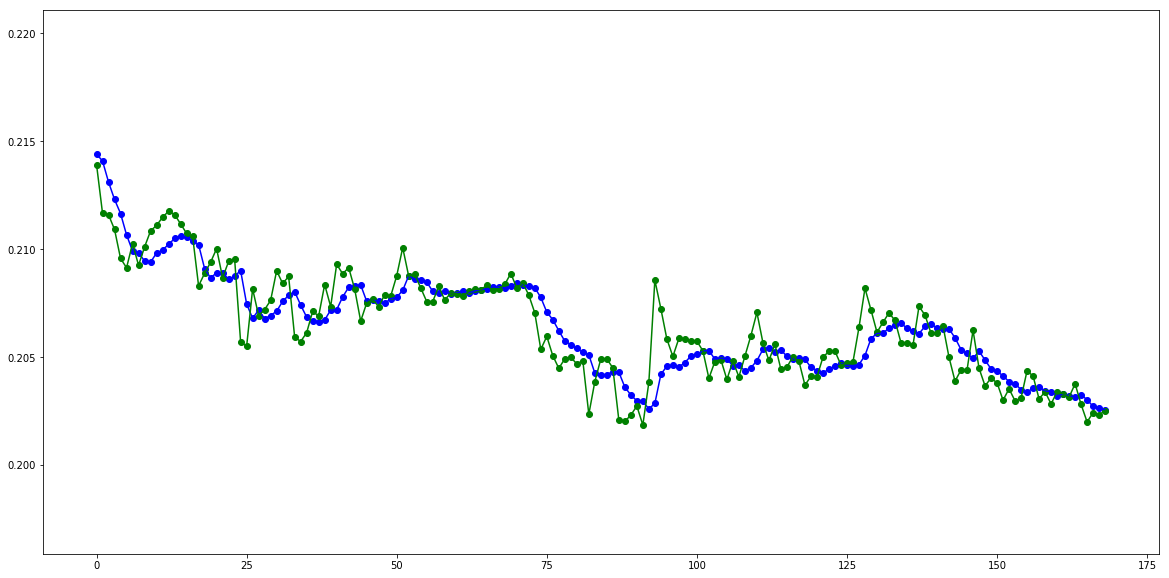

In [41]:
plt.figure(figsize=(20,10))
for color in ['blue']:
    color_df = visualizer.date_pred_targ_dict.get(color, pd.DataFrame())
    plt.scatter(color_df.iloc[:,0], color_df.iloc[:, -2]*10, color=color)
    plt.plot(color_df.iloc[:,0], color_df.iloc[:, -2]*10, color=color)
    plt.scatter(color_df.iloc[:,0], color_df.iloc[:, -1]*10, color='g')
    plt.plot(color_df.iloc[:,0], color_df.iloc[:, -1]*10, color='g')
plt.show()

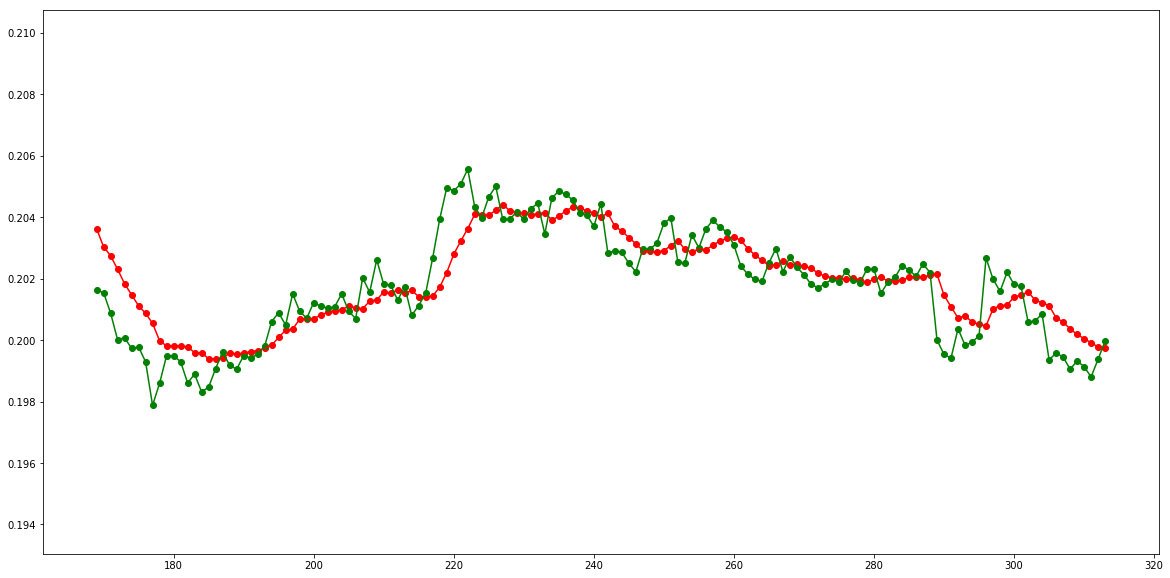

In [42]:
plt.figure(figsize=(20,10))

for color in ['red']:
    color_df = visualizer.date_pred_targ_dict.get(color, pd.DataFrame())
    plt.scatter(color_df.iloc[:,0], color_df.iloc[:, -2]*10, color=color)
    plt.plot(color_df.iloc[:,0], color_df.iloc[:, -2]*10, color=color)
    plt.scatter(color_df.iloc[:,0], color_df.iloc[:, -1]*10, color='g')
    plt.plot(color_df.iloc[:,0], color_df.iloc[:, -1]*10, color='g')
plt.show()

# should try estimate (min / max) on next 4 timestamps